<img style="float: left" src="https://upload.wikimedia.org/wikipedia/commons/d/db/Logo_ITESO_normal.jpg" width ="110px"/>


 # <p style="text-align: center">  <font color = 'darkblue'> PAP - Predicción de consumo de energía en días festivos
    
 ### <p style="text-align: center">  <font color = 'darkblue'> Consumo diario

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
#from xlrd.xldate import xldate_as_tuple
import numpy as np
from datetime import datetime
from calendar import monthrange
import scipy as sp
from pandas import Series
from numpy import polynomial
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import sklearn
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
#plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm

from pylab import rcParams

# <p style="text-align: center">  <font color = 'darkblue'> Primera Parte
### <p style="text-align: center">  <font color = 'black'> Pruebas Estadísticas

In [2]:
# Acomodo de datos
df = pd.read_excel("datos.xlsx") #leyendo los datos
df = df.set_index("fecha") #establece la fecha como el index

dates = pd.read_csv("fechas.csv")
dates['Fecha'] = pd.to_datetime(dates['Fecha']) 
dates = dates.set_index("Fecha")

names = ['año nuevo','aniversario de la Constitución de 1917','natalicio de Benito Juárez Garcia',
        'jueves santo','viernes santo','día del trabajo',
        'día de la madre','día de la Independencia',
        'día de la Virgen de Zapopan','día de los muertos',
        'día de la Revolución','día de la Virgen de Guadalupe',
        'Navidad']
data = df.join(dates)
data = data.dropna()

# Proyecciones
real = pd.DataFrame(index = ['Valor Real'],columns = names)
pred = pd.DataFrame(index = ['Regresión lineal 1 var','Regresión lineal multivar','ARIMA'],columns = names)

### <font color = 'black'> Representación visual

In [3]:
#Funcion para obtener días anteriores y posteriores

def ant_post(mes):

    consumo_ =pd.DataFrame()
    _consumo =pd.DataFrame()
    consumo = pd.DataFrame()
    
    m = dates.index[mes].month
    nn= monthrange(2002, m)
    n = nn[1]
    
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index.month[mes]
        day = dates.index.day[mes]
    

    for i in range(0,5):
        day_ = day + i    
        z = list(df[(df.index.month == month) & (df.index.day == day_)]['MWh'])
        consumo_[i] = pd.Series(z)
        if day <=(i+1):
            _day = n-(i+1)+day
        else:
            _day = day - i
        y = list(df[(df.index.month == month) & (df.index.day == _day)]['MWh'])
        _consumo[i+5] = pd.Series(y)

    consumo = pd.concat([consumo_ , _consumo],axis=1)
    cols = [ 9, 8, 7, 6 ,5, 1, 2,3, 4, 5]
    consumo = consumo[cols]
    consumo.columns=['-5','-4','-3','-2','-1','Day','+1','+2','+3','+4']
    return(consumo)

#### Gráfica de barras

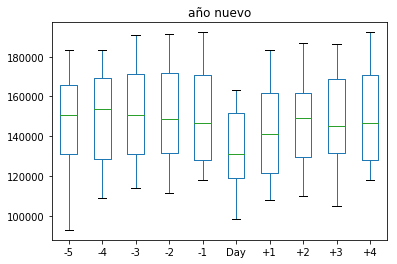

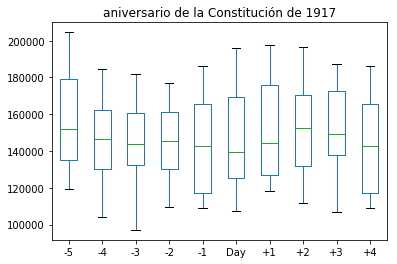

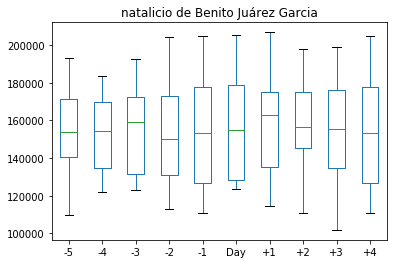

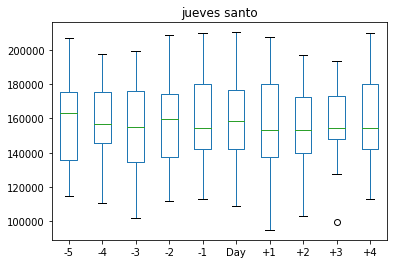

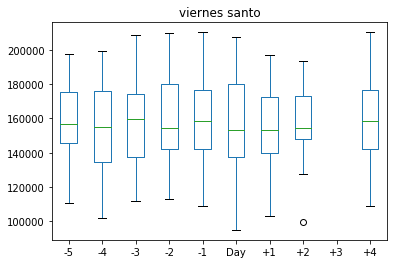

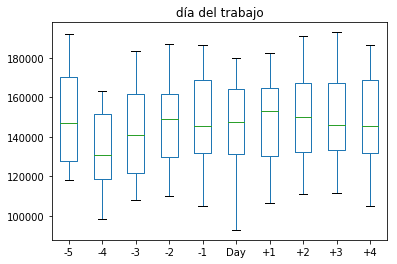

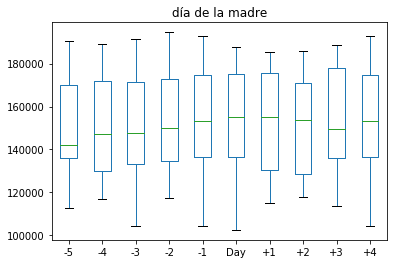

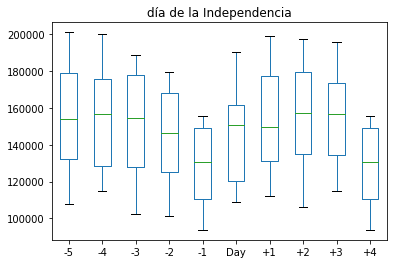

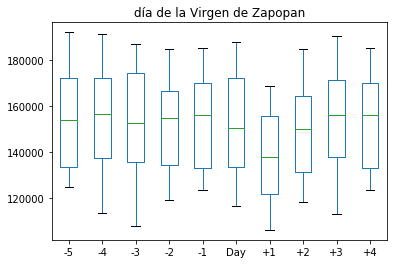

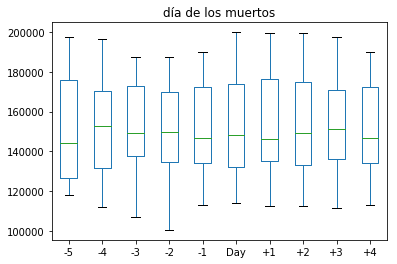

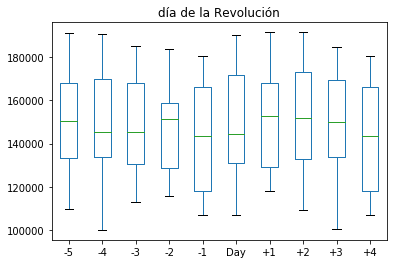

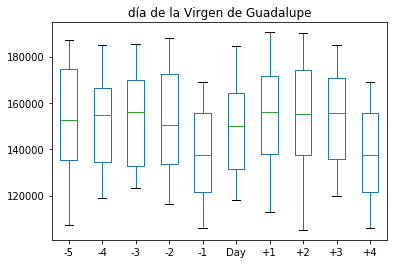

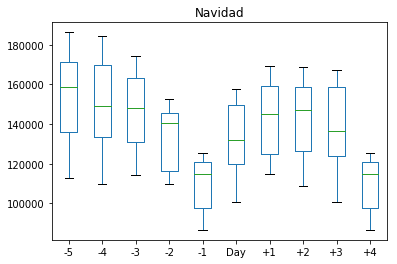

In [4]:
for i in range(len(names)):
    consumo=ant_post(i)
    consumo.plot(kind='box')
    plt.title(names[i])
    

#### Gráfica de Variaciones con respecto al año anterior

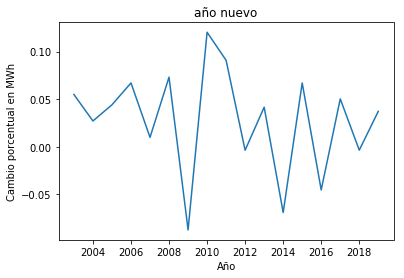

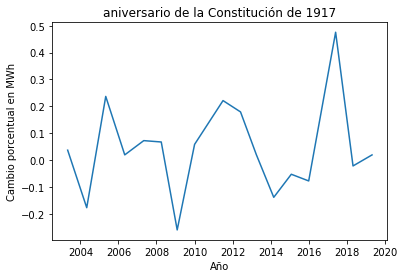

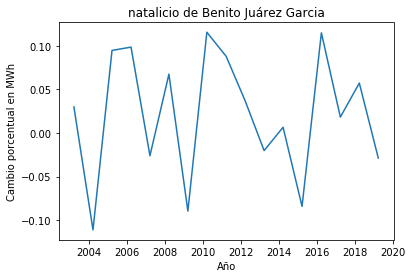

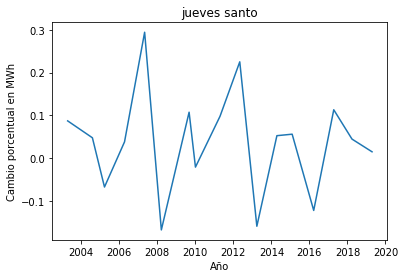

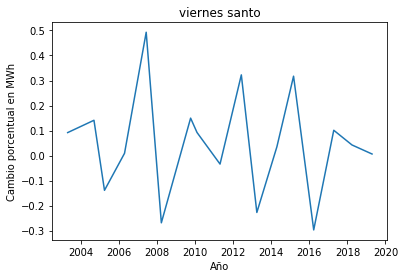

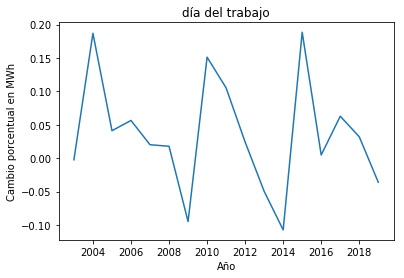

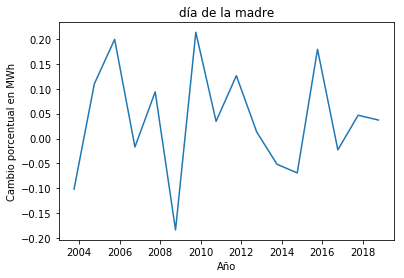

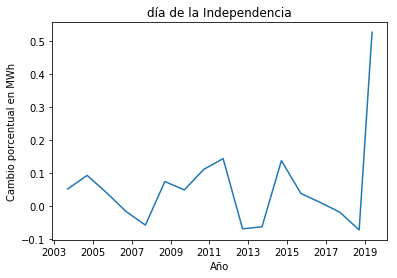

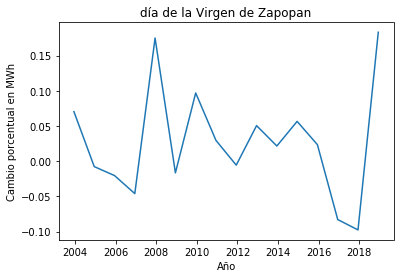

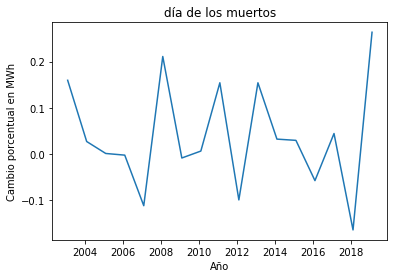

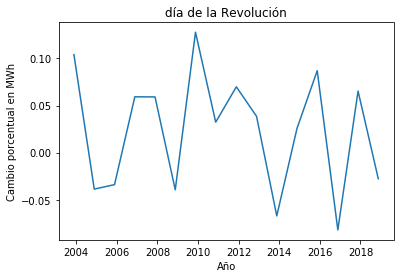

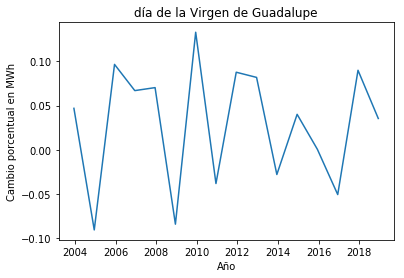

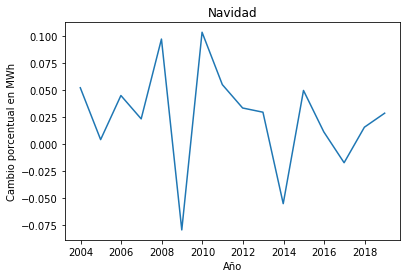

In [5]:
# Calcular variaciones (año con año)
for i in range(len(names)):
    change = data[(data.Conmemoracion==names[i])]['MWh'].pct_change().dropna()
    plt.figure(i)
    plt.plot(change)
    plt.title(names[i])
    plt.xlabel('Año')
    plt.ylabel('Cambio porcentual en MWh')


#### Gráfica de Variación con respecto al año anterior

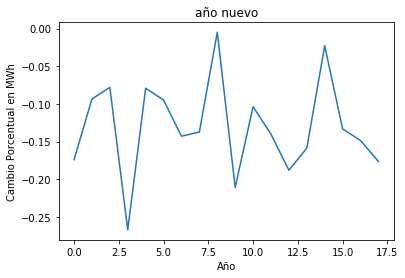

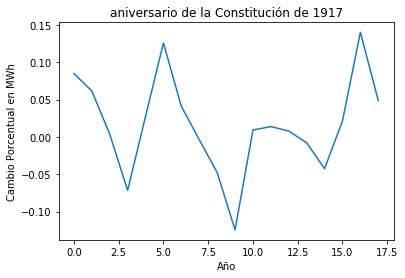

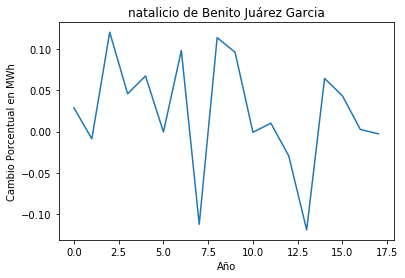

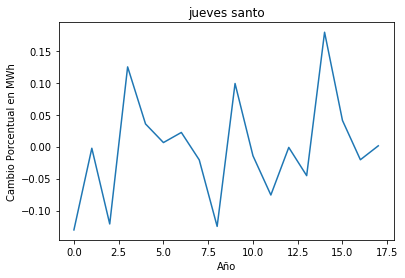

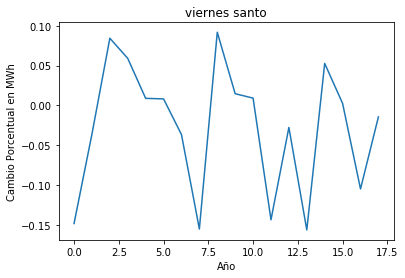

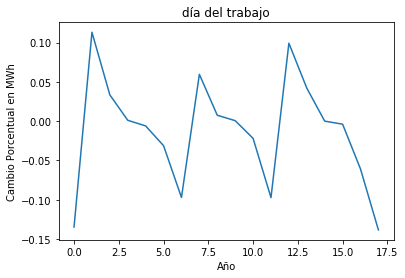

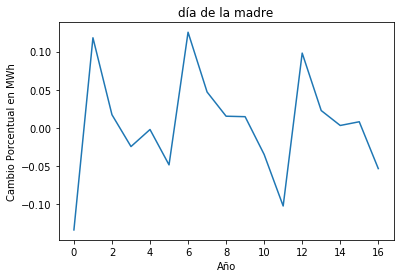

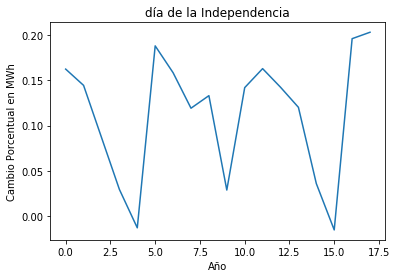

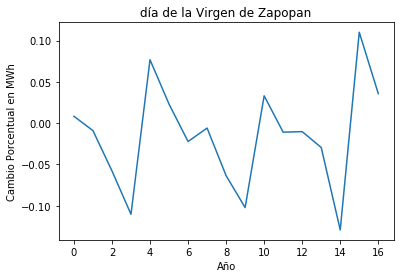

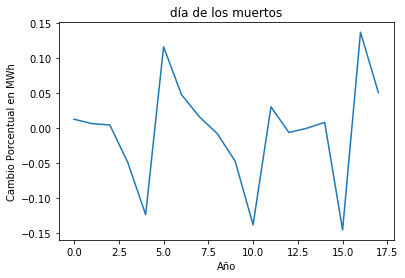

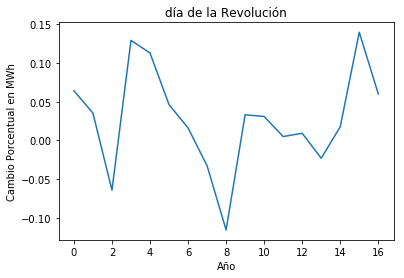

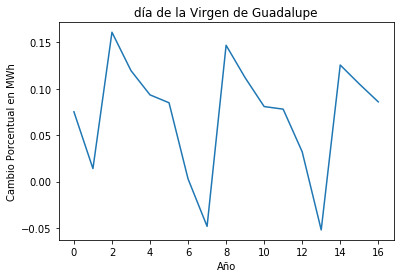

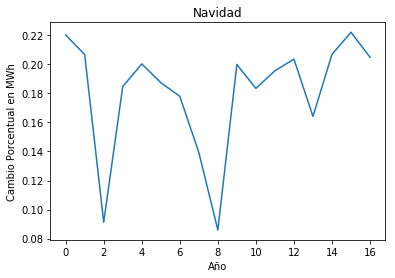

In [6]:
# De un dia a otro

for i in range(len(names)):
    a = ant_post(i)
    a_d1 = (a['Day']-a['-1'])/a['Day']
    plt.figure(i)
    plt.plot(a_d1)
    plt.title(names[i])
    plt.xlabel('Año')
    plt.ylabel('Cambio Porcentual en MWh')

### Pruebas y tendencias

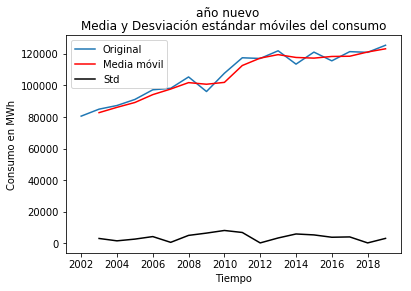

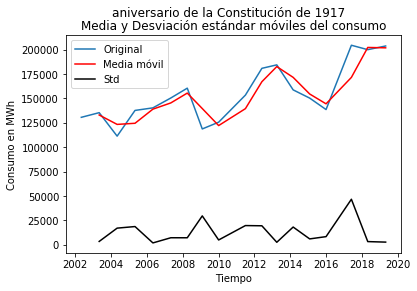

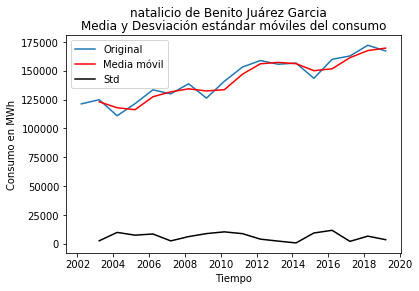

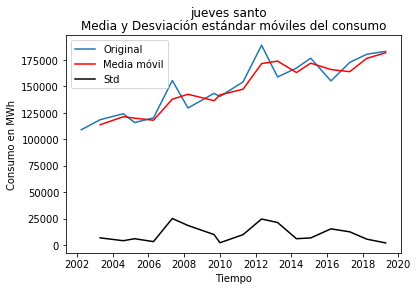

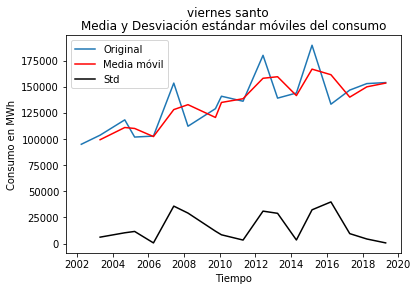

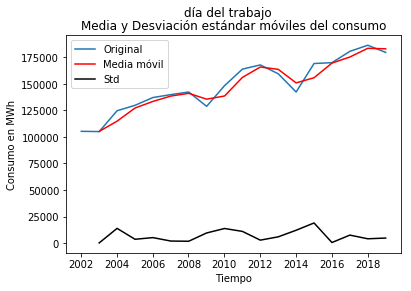

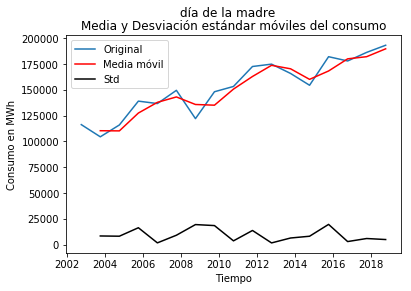

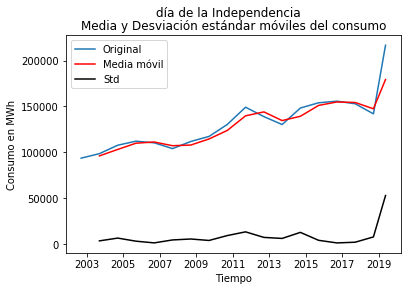

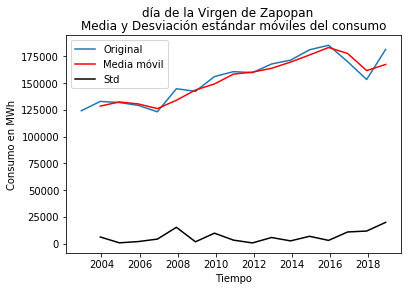

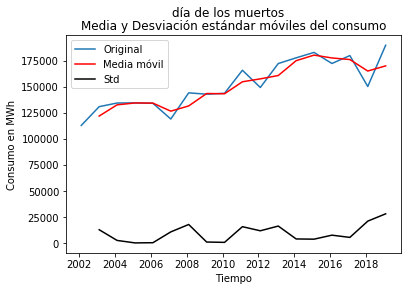

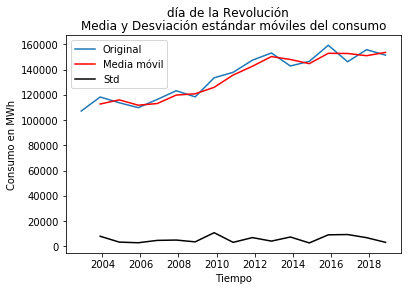

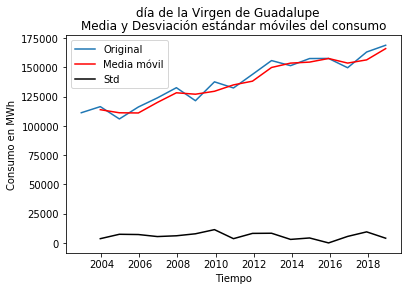

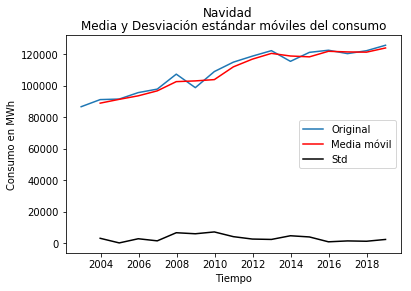

In [7]:
for i in range(len(names)):
    rolling_mean = data[(data.Conmemoracion==names[i])]['MWh'].rolling(window = 2).mean()
    rolling_std = data[(data.Conmemoracion==names[i])]['MWh'].rolling(window = 2).std()
    plt.figure(i)
    plt.plot(data[(data.Conmemoracion==names[i])]['MWh'], label = 'Original')
    plt.plot(rolling_mean, color = 'red', label = 'Media móvil')
    plt.plot(rolling_std, color = 'black', label = 'Std')
    plt.legend(loc = 'best')
    plt.title('Media y Desviación estándar móviles del consumo')
    plt.suptitle(names[i])
    plt.ylabel('Consumo en MWh')
    plt.xlabel('Tiempo')
    plt.show()

In [8]:
#PRUEBA DICKEY FULLER PARA ESTACIONARIEDAD

for i in range(len(names)):
    result = adfuller(data[(data.Conmemoracion==names[i])]['MWh'].dropna())
    print('Resultados de',names[i],':')
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))
    print('-------------------------------------------')

Resultados de año nuevo :
ADF Statistic: 0.0
p-value: 0.958532086060056
Critical Values:
	1%: -4.473135048010974
	5%: -3.28988060356653
	10%: -2.7723823456790124
-------------------------------------------
Resultados de aniversario de la Constitución de 1917 :
ADF Statistic: -0.07374319202876141
p-value: 0.9519918222880315
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: -2.7487
-------------------------------------------
Resultados de natalicio de Benito Juárez Garcia :
ADF Statistic: -0.0
p-value: 0.958532086060056
Critical Values:
	1%: -4.473135048010974
	5%: -3.28988060356653
	10%: -2.7723823456790124
-------------------------------------------
Resultados de jueves santo :
ADF Statistic: -0.6444537691375299
p-value: 0.8606176757312339
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: -2.7487
-------------------------------------------
Resultados de viernes santo :
ADF Statistic: -1.057087448023829
p-value: 0.7318782061188752
Critical Values:
	1%: -4.331573
	5%: -3.23295
	10%: 

# <p style="text-align: center">  <font color = 'darkblue'> Segunda Parte
### <p style="text-align: center">  <font color = 'black'> Proyecciones

In [3]:
# librerias
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
import matplotlib.gridspec as gridspec
import itertools

### Acomodo de base de datos

In [4]:
comp = pd.read_excel('Consumo GCROC 2002-2019-2.xlsx', 'datos' ,usecols='B:J')
comp.columns = ['MWh', 'Temp min', 'Temp max', 'Temp prom',
               'borrar','borrar1','Vel viento', 'dia sem']
comp =comp.drop(['borrar','borrar1'], axis =1)
comp =comp.drop('fecha',axis = 0)

fechas_comp = pd.DataFrame(data['Conmemoracion']).join(comp)
fechas_comp = fechas_comp.dropna()

In [11]:
def ant_post(mes):

    consumo = pd.DataFrame()
    
    m = dates.index[mes].month
    nn= monthrange(2002, m)
    n = nn[1]
    
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index.month[mes]
        day = dates.index.day[mes]
    

    for i in range(0,5):
        day_ = day + i    
        z = list(df[(df.index.month == month) & (df.index.day == day_)]['MWh'])
        consumo_[i] = pd.Series(z)
        if day <=(i+1):
            _day = n-(i+1)+day
        else:
            _day = day - i
        y = list(df[(df.index.month == month) & (df.index.day == _day)]['MWh'])
        _consumo[i+5] = pd.Series(y)

    consumo = pd.concat([consumo_ , _consumo],axis=1)
    cols = [ 9, 8, 7, 6 ,5, 1, 2,3, 4, 5]
    consumo = consumo[cols]
    consumo.columns=['-5','-4','-3','-2','-1','Day','+1','+2','+3','+4']
    return(consumo)

In [5]:
def ant_one(mes):
    consumo_ =pd.DataFrame()
    if dates['Conmemoracion'][mes] == names[mes]:
        month= dates.index[mes].month
        day = dates.index[mes].day
        nn= monthrange(2002, month)
        n = nn[1]
    if day <=1:
        _day = n
        month = 12
    else: 
        _day = day - 1
        
    z = list(df[(df.index.month == month) & (df.index.day == _day)]['MWh'])
    consumo_= pd.Series(z)

    return(consumo_)

###  <p style="text-align: center">  <font color = 'blue'>Regresión linear

In [6]:
def reg_1v(df,name):
    X = df.iloc[0:14,5]
    Y = df.iloc[0:14,0]
    test = np.reshape(X.iloc[-1],1)
    print(test)
    print("\n")
    X = np.reshape(np.asarray(X), (len(X), 1))
    test_size = 0.20
    n=round(len(X)*(1-test_size))
    X_train = X[0:n,:]
    Y_train = Y[0:n]
    X_test =  X[n:len(X),:]
    Y_test = Y[n:len(X)]
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict([X_test[0],X_test[1],X_test[2]])
    print('prediccion: ', Y_pred)
    print("\n")
    print('real: ', Y[n:len(Y)])
    print("\n")
    print('Coefficients: \n', lr.coef_)
    print("\n")
    print('Intercept: \n', lr.intercept_)
    print("\n")
    X = sm.add_constant(X)
    Y_train = list(Y_train)
    temporal = np.asarray(X_train)
    X_train = temporal.tolist() 

 

    temporal2 = np.asarray(X_test)
    X_test = temporal2.tolist()

    pred[name]['Regresión lineal 1 var'] = Y_pred[0]

    model0 = sm.OLS(Y_train, X_train).fit()
    predictions0 = model0.predict([X_test]) 
    print(predictions0)
    print("\n")
    
    real = Y[-1]
    error = (predictions0-real)/real*100
    print("error: ", error)
    print("\n")
    print_model0 = model0.summary()
    return print_model0

In [7]:
def reg_av(df,name):
    X = df.iloc[0:14,1:6]
    Y = df.iloc[0:14,0]
    test = np.reshape(X.iloc[-1],5)
    print(test)
    X = np.reshape(X,(len(X),5))
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.2)
    lr = linear_model.LinearRegression()
    lr.fit(X_train, Y_train)
    Y_pred = lr.predict([test])
    
    pred[name]['Regresión lineal multivar'] = Y_pred[0]
    
    print('prediccion: ', Y_pred)
    print('real: ', Y[-1])
    print('Coefficients: \n', lr.coef_)
    print('Intercept: \n', lr.intercept_)
    X = sm.add_constant(X)
    Y_train = list(Y_train)
    temporal = np.asarray(X_train)
    X_train = temporal.tolist() 

 

    temporal2 = np.asarray(X_test)
    X_test = temporal2.tolist()

 

    model0 = sm.OLS(Y_train, X_train).fit()
    predictions0 = model0.predict([test]) 
    print(predictions0)
    
    real = Y[-1]
    error = (predictions0-real)/real*100
    print("error: ", error)
    print_model0 = model0.summary()
    return print_model0

#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

In [8]:
a_nuevo = fechas_comp[(fechas_comp.Conmemoracion == names[0])].drop(['Conmemoracion'], axis =1)
a_nuevo['Dia ant'] = list(ant_one(0))
real['año nuevo'] = a_nuevo['MWh'][15]

In [9]:
# Regresión con una sola variable
reg_1v(a_nuevo,'año nuevo')

[4]


prediccion:  [92172.00232922 94910.00158436 97648.00083951]


real:  fecha
2013-01-01    121834
2014-01-01    113393
2015-01-01    120995
Name: MWh, dtype: object


Coefficients: 
 [2737.99925514]


Intercept: 
 86696.00381893002


[[38738.95507755 58108.43261633 77477.9101551 ]]


error:  [[-67.98293807 -51.9744071  -35.96587614]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.851
Model:                            OLS   Adj. R-squared:                  0.836
Method:                 Least Squares   F-statistic:                     57.07
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.94e-05
Time:                        09:39:26   Log-Likelihood:                -131.68
No. Observations:                  11   AIC:                             265.4
Df Residuals:                      10   BIC:                             265.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1.937e+04   2563.967      7.554      0.000    1.37e+04    2.51e+04
==============================================================================
Omnibus:                        0.345   Durbin-Watson:                   1.157
Prob(Omnibus):                  0.841   Jarque-Bera (JB):                0.451
Skew:                           0.284   Prob(JB):                        0.798
Kurtosis:                       2.187   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [10]:
#Regresión todas las variables
reg_av(a_nuevo, 'año nuevo')

Temp min      11.5714
Temp max      26.5714
Temp prom     19.0714
Vel viento         27
dia sem             4
Name: 2015-01-01 00:00:00, dtype: object
prediccion:  [101807.82809091]
real:  120994.722
Coefficients: 
 [-7.0157315e+17 -7.0157315e+17  1.4031463e+18  3.8400000e+02
  2.4315000e+03]
Intercept: 
 28465.828090909083
[104942.42592493261]
error:  [-13.266939094308084]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     221.4
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.91e-07
Time:                        09:39:27   Log-Likelihood:                -115.99
No. Observations:                  11   AIC:                             240.0
Df Residuals:                       7   BIC:                             241.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          5247.1168   2258.358      2.323      0.053     -93.051    1.06e+04
x2          -429.8774   1246.423     -0.345      0.740   -3377.200    2517.445
x3          2408.6197    846.276      2.846      0.025     407.495    4409.744
x4            44.6943   1216.241      0.037      0.972   -2831.258    2920.647
x5          2126.4194   2161.822      0.984      0.358   -2985.478    7238.317
==============================================================================
Omnibus:                        1.367   Durbin-Watson:                   1.664
Prob(Omnibus):                  0.505   Jarque-Bera (JB):                0.828
Skew:                           0.298   Prob(JB):                        0.661
Kurtosis:                       1.795   Cond. No.                     3.11e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.06e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

In [11]:
a_const = fechas_comp[(fechas_comp.Conmemoracion == names[1])].drop(['Conmemoracion','dia sem'], axis =1)
a_const['Dia ant'] = list(ant_one(1))
real['aniversario de la Constitución de 1917'] = a_const['MWh'][15]

In [12]:
reg_1v(a_const, 'aniversario de la Constitución de 1917')

[176774.83]


prediccion:  [148716.06469242 156877.77748529 161504.40286436]


real:  fecha
2013-04-02    184366
2014-03-02    158730
2015-02-02    150294
Name: MWh, dtype: object


Coefficients: 
 [0.48544363]


Intercept: 
 75690.18755701711


[[157461.16890477 175059.76391033 185035.86921504]]


error:  [[ 4.76885087 16.47830653 23.11603884]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     521.6
Date:                Tue, 12 May 2020   Prob (F-statistic):           5.84e-10
Time:                        09:39:27   Log-Likelihood:                -124.23
No. Observations:                  11   AIC:                             250.5
Df Residuals:                      10   BIC:                             250.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0467      0.046     22.839      0.000       0.945       1.149
==============================================================================
Omnibus:                        3.023   Durbin-Watson:                   1.536
Prob(Omnibus):                  0.221   Jarque-Bera (JB):                1.056
Skew:                          -0.189   Prob(JB):                        0.590
Kurtosis:                       1.530   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [13]:
reg_av(a_const,'aniversario de la Constitución de 1917')

Temp min      13.0714
Temp max      21.5714
Temp prom     17.3214
Vel viento         27
Dia ant        176775
Name: 2015-02-02 00:00:00, dtype: object
prediccion:  [129866.40549103]
real:  150293.878
Coefficients: 
 [7.48421197e+02 2.93176556e+03 1.84009338e+03 3.53189398e+03
 4.69525295e-01]
Intercept: 
 -153393.3377153776
[131773.06566725907]
error:  [-12.323065037114105]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     175.9
Date:                Tue, 12 May 2020   Prob (F-statistic):           4.24e-07
Time:                        09:39:27   Log-Likelihood:                -120.95
No. Observations:                  11   AIC:                             249.9
Df Residuals:                       7   BIC:                             251.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           959.7222   2601.325      0.369      0.723   -5191.433    7110.877
x2           861.5819   1691.517      0.509      0.626   -3138.221    4861.385
x3           910.6520    768.703      1.185      0.275    -907.042    2728.346
x4          3251.6342   2667.062      1.219      0.262   -3054.965    9558.234
x5            -0.0165      0.501     -0.033      0.975      -1.202       1.168
==============================================================================
Omnibus:                        0.871   Durbin-Watson:                   1.798
Prob(Omnibus):                  0.647   Jarque-Bera (JB):                0.626
Skew:                           0.510   Prob(JB):                        0.731
Kurtosis:                       2.429   Cond. No.                     1.46e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.7e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez Garcia

In [14]:
nat_bj = fechas_comp[(fechas_comp.Conmemoracion == names[2])].drop(['Conmemoracion','dia sem'], axis =1)
nat_bj['Dia ant'] = list(ant_one(2))
real['natalicio de Benito Juárez Garcia'] = nat_bj['MWh'][15]

In [15]:
reg_1v(nat_bj,'natalicio de Benito Juárez Garcia')

[172107.086]


prediccion:  [158032.60586438 161853.48643784 152981.41786016]


real:  fecha
2013-03-18    155634
2014-03-17    156639
2015-03-16    143449
Name: MWh, dtype: object


Coefficients: 
 [0.62930135]


Intercept: 
 44674.19564761236


[[170134.20842484 175868.78507079 162553.12228346]]


error:  [[18.60219924 22.59982798 13.3173509 ]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.994
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     1607.
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.23e-12
Time:                        09:39:27   Log-Likelihood:                -117.45
No. Observations:                  11   AIC:                             236.9
Df Residuals:                      10   BIC:                             237.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9445      0.024     40.085      0.000       0.892       0.997
==============================================================================
Omnibus:                        2.507   Durbin-Watson:                   2.805
Prob(Omnibus):                  0.286   Jarque-Bera (JB):                0.990
Skew:                           0.208   Prob(JB):                        0.610
Kurtosis:                       1.591   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
reg_av(nat_bj,'natalicio de Benito Juárez Garcia')

Temp min        12.5
Temp max          18
Temp prom      15.25
Vel viento        28
Dia ant       172107
Name: 2015-03-16 00:00:00, dtype: object
prediccion:  [145525.88371755]
real:  143449.455
Coefficients: 
 [-2.65569213e+03  1.18221899e+03 -7.36736570e+02  1.18500863e+03
  5.03877953e-01]
Intercept: 
 48776.1183733628
[142443.0659151089]
error:  [-0.7015635471679527]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.994
Method:                 Least Squares   F-statistic:                     486.2
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.24e-08
Time:                        09:39:27   Log-Likelihood:                -115.10
No. Observations:                  11   AIC:                             238.2
Df Residuals:                       7   BIC:                             239.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1342.2009   2676.275     -0.502      0.631   -7670.585    4986.183
x2          1247.0183   1257.889      0.991      0.355   -1727.416    4221.453
x3           -47.5913    785.889     -0.061      0.953   -1905.923    1810.740
x4          1223.1407   1053.532      1.161      0.284   -1268.066    3714.348
x5             0.5999      0.158      3.802      0.007       0.227       0.973
==============================================================================
Omnibus:                        0.057   Durbin-Watson:                   1.652
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.247
Skew:                           0.123   Prob(JB):                        0.884
Kurtosis:                       2.309   Cond. No.                     5.20e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.89e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

In [17]:
js = fechas_comp[(fechas_comp.Conmemoracion == names[3])].drop(['Conmemoracion','dia sem'], axis =1)
js['Dia ant'] = list(ant_one(3))
real['jueves santo'] = js['MWh'][15]

In [18]:
reg_1v(js, 'jueves santo')

[177289.361]


prediccion:  [164396.13399141 175973.31150829 166739.94534811]


real:  fecha
2013-03-28    159013
2014-04-17    167382
2015-02-04    176775
Name: MWh, dtype: object


Coefficients: 
 [0.94170572]


Intercept: 
 -214.45930170238717


[[164356.68374471 175916.00362645 166696.87980502]]


error:  [[-7.02483847 -0.48583069 -5.70100969]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     1134.
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.26e-11
Time:                        09:39:27   Log-Likelihood:                -119.74
No. Observations:                  11   AIC:                             241.5
Df Residuals:                      10   BIC:                             241.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9403      0.028     33.670      0.000       0.878       1.002
==============================================================================
Omnibus:                        1.371   Durbin-Watson:                   1.885
Prob(Omnibus):                  0.504   Jarque-Bera (JB):                0.972
Skew:                           0.648   Prob(JB):                        0.615
Kurtosis:                       2.337   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
reg_av(js,'jueves santo')

Temp min      10.4286
Temp max      24.8571
Temp prom     17.6429
Vel viento         27
Dia ant        177289
Name: 2015-02-04 00:00:00, dtype: object
prediccion:  [165798.83460585]
real:  176774.83
Coefficients: 
 [-2.93456956e+01 -2.65956632e+02 -1.47651164e+02 -1.09515328e+03
  9.40052003e-01]
Intercept: 
 38228.698331574866
[163242.2278901305]
error:  [-7.65527655145785]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     418.5
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.09e-08
Time:                        09:39:27   Log-Likelihood:                -116.06
No. Observations:                  11   AIC:                             240.1
Df Residuals:                       7   BIC:                             241.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           498.0879   1929.959      0.258      0.804   -4065.540    5061.716
x2          -207.7012   1798.972     -0.115      0.911   -4461.594    4046.192
x3           145.1933    303.058      0.479      0.646    -571.425     861.811
x4          -538.4269   1164.449     -0.462      0.658   -3291.911    2215.057
x5             0.9881      0.161      6.149      0.000       0.608       1.368
==============================================================================
Omnibus:                        1.953   Durbin-Watson:                   1.441
Prob(Omnibus):                  0.377   Jarque-Bera (JB):                1.295
Skew:                           0.780   Prob(JB):                        0.523
Kurtosis:                       2.373   Cond. No.                     8.58e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.58e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

In [20]:
vs = fechas_comp[(fechas_comp.Conmemoracion == names[4])].drop(['Conmemoracion','dia sem'], axis =1)
vs['Dia ant'] = list(ant_one(4))
real['viernes santo'] = vs['MWh'][15]

In [21]:
reg_1v(vs,'viernes santo')

[178946.184]


prediccion:  [155817.7025119  175249.53520388 165103.91420218]


real:  fecha
2013-03-29    139054
2014-04-18    143945
2015-03-04    189617
Name: MWh, dtype: object


Coefficients: 
 [1.17691028]


Intercept: 
 -45499.68985345212


[[148335.85175629 162653.72772161 155178.17225568]]


error:  [[-21.77084963 -14.21990859 -18.16235639]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     745.6
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.00e-10
Time:                        09:39:27   Log-Likelihood:                -121.12
No. Observations:                  11   AIC:                             244.2
Df Residuals:                      10   BIC:                             244.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8672      0.032     27.306      0.000       0.796       0.938
==============================================================================
Omnibus:                        0.401   Durbin-Watson:                   2.388
Prob(Omnibus):                  0.819   Jarque-Bera (JB):                0.484
Skew:                           0.174   Prob(JB):                        0.785
Kurtosis:                       2.033   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
reg_av(vs,'viernes santo')

Temp min         12.5
Temp max      28.8571
Temp prom     20.6786
Vel viento         27
Dia ant        178946
Name: 2015-03-04 00:00:00, dtype: object
prediccion:  [158528.68529059]
real:  189617.107
Coefficients: 
 [-4.17255698e+02  1.72570201e+01 -1.99999339e+02 -2.25557154e+03
  1.06847073e+00]
Intercept: 
 37083.76518127549
[157106.9608148959]
error:  [-17.145154622100684]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.985
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     112.4
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.99e-06
Time:                        09:39:28   Log-Likelihood:                -122.22
No. Observations:                  11   AIC:                             252.4
Df Residuals:                       7   BIC:                             254.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -519.0920   3504.283     -0.148      0.886   -8805.405    7767.221
x2           695.8470   3299.459      0.211      0.839   -7106.134    8497.828
x3            88.3775    603.476      0.146      0.888   -1338.617    1515.371
x4         -1811.7329   2102.653     -0.862      0.417   -6783.717    3160.251
x5             1.0652      0.311      3.429      0.011       0.331       1.800
==============================================================================
Omnibus:                        0.486   Durbin-Watson:                   2.500
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.257
Skew:                           0.322   Prob(JB):                        0.880
Kurtosis:                       2.620   Cond. No.                     4.70e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.16e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día del trabajo

In [23]:
dt = fechas_comp[(fechas_comp.Conmemoracion == names[5])].drop(['Conmemoracion','dia sem'], axis =1)
dt['Dia ant'] = list(ant_one(5))
real['día del trabajo'] = dt['MWh'][15]

In [24]:
reg_1v(dt,'día del trabajo')

[151670.946]


prediccion:  [163970.94872675 156523.1186899  153260.88891246]


real:  fecha
2013-01-05    159502
2014-01-05    142356
2015-01-05    169182
Name: MWh, dtype: object


Coefficients: 
 [0.9711552]


Intercept: 
 5964.860629474744


[[165129.20277772 157345.61512475 153936.31989497]]


error:  [[-2.39569526 -6.99640579 -9.01156655]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     4128.
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.03e-14
Time:                        09:39:28   Log-Likelihood:                -112.58
No. Observations:                  11   AIC:                             227.2
Df Residuals:                      10   BIC:                             227.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0149      0.016     64.246      0.000       0.980       1.050
==============================================================================
Omnibus:                        0.731   Durbin-Watson:                   1.940
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.490
Skew:                           0.454   Prob(JB):                        0.783
Kurtosis:                       2.505   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
reg_av(dt,'día del trabajo')

Temp min      11.1429
Temp max      21.8571
Temp prom        16.5
Vel viento         27
Dia ant        151671
Name: 2015-01-05 00:00:00, dtype: object
prediccion:  [155154.39758572]
real:  169182.295
Coefficients: 
 [   2.65560345 -531.9510193  -264.64770793 -137.67686783    0.74866217]
Intercept: 
 61285.39914090492
[153655.6400367954]
error:  [-9.177470351259041]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     703.5
Date:                Tue, 12 May 2020   Prob (F-statistic):           3.42e-09
Time:                        09:39:28   Log-Likelihood:                -113.52
No. Observations:                  11   AIC:                             235.0
Df Residuals:                       7   BIC:                             236.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1682.0739   2492.753      0.675      0.521   -4212.351    7576.499
x2          -236.5164   1336.184     -0.177      0.865   -3396.088    2923.056
x3           722.7788    727.849      0.993      0.354    -998.310    2443.868
x4            93.5498    795.501      0.118      0.910   -1787.511    1974.611
x5             0.8283      0.138      6.019      0.001       0.503       1.154
==============================================================================
Omnibus:                        1.078   Durbin-Watson:                   1.663
Prob(Omnibus):                  0.583   Jarque-Bera (JB):                0.050
Skew:                           0.137   Prob(JB):                        0.976
Kurtosis:                       3.183   Cond. No.                     3.05e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.44e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de la madre

In [26]:
d_madre = fechas_comp[(fechas_comp.Conmemoracion == names[6])].drop(['Conmemoracion','dia sem'], axis =1)
d_madre['Dia ant'] = list(ant_one(6))
real['día de la madre'] = d_madre['MWh'][15]


In [27]:
reg_1v(d_madre,'día de la madre')

[163463.841]


prediccion:  [171531.94974291 176017.96961883 165585.02837441]


real:  fecha
2013-10-05    165759
2014-10-05    154318
2015-10-05    181982
Name: MWh, dtype: object


Coefficients: 
 [1.11147998]


Intercept: 
 -16101.757589478279


[[168521.98589877 172551.07528265 163180.7974031 ]]


error:  [[ -7.39625307  -5.18224656 -10.33126517]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2957.
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.07e-13
Time:                        09:39:29   Log-Likelihood:                -114.72
No. Observations:                  11   AIC:                             231.4
Df Residuals:                      10   BIC:                             231.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9983      0.018     54.378      0.000       0.957       1.039
==============================================================================
Omnibus:                        3.934   Durbin-Watson:                   2.264
Prob(Omnibus):                  0.140   Jarque-Bera (JB):                1.083
Skew:                           0.610   Prob(JB):                        0.582
Kurtosis:                       3.935   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [28]:
reg_av(d_madre,'día de la madre')

Temp min      16.9286
Temp max         28.5
Temp prom     22.7143
Vel viento      23.25
Dia ant        163464
Name: 2015-10-05 00:00:00, dtype: object
prediccion:  [157882.77375792]
real:  181981.822
Coefficients: 
 [-6.78113616e+02  3.78006311e+03  1.55097475e+03  1.71760692e+03
  9.03938003e-01]
Intercept: 
 -161294.35275732586
[157529.6639935351]
error:  [-13.436593687068859]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.993
Method:                 Least Squares   F-statistic:                     404.4
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.36e-08
Time:                        09:39:29   Log-Likelihood:                -116.05
No. Observations:                  11   AIC:                             240.1
Df Residuals:                       7   BIC:                             241.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -363.7230   2076.001     -0.175      0.866   -5272.685    4545.239
x2           248.7482   2015.987      0.123      0.905   -4518.304    5015.800
x3           -57.4874    613.719     -0.094      0.928   -1508.702    1393.728
x4           556.7232   1500.428      0.371      0.722   -2991.224    4104.671
x5             0.8868      0.182      4.883      0.002       0.457       1.316
==============================================================================
Omnibus:                        0.486   Durbin-Watson:                   1.580
Prob(Omnibus):                  0.784   Jarque-Bera (JB):                0.206
Skew:                           0.294   Prob(JB):                        0.902
Kurtosis:                       2.676   Cond. No.                     2.72e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.06e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

In [29]:
d_ind = fechas_comp[(fechas_comp.Conmemoracion == names[7])].drop(['Conmemoracion','dia sem'], axis =1)
d_ind['Dia ant'] = list(ant_one(7))
real['día de la Independencia'] = d_ind['MWh'][15]

In [30]:
reg_1v(d_ind,'día de la Independencia')

[178834.969]


prediccion:  [123227.04743525 135951.93078287 152349.68263699]


real:  fecha
2013-09-16    130330
2014-09-16    148317
2015-09-16    154054
Name: MWh, dtype: object


Coefficients: 
 [0.77965524]


Intercept: 
 12920.06225509246


[[123826.08815445 138110.51923181 156517.9615466 ]]


error:  [[-19.62159996 -10.34924279   1.59945706]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     9668.
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.90e-16
Time:                        09:39:30   Log-Likelihood:                -106.16
No. Observations:                  11   AIC:                             214.3
Df Residuals:                      10   BIC:                             214.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8752      0.009     98.327      0.000       0.855       0.895
==============================================================================
Omnibus:                        0.767   Durbin-Watson:                   1.811
Prob(Omnibus):                  0.681   Jarque-Bera (JB):                0.599
Skew:                          -0.113   Prob(JB):                        0.741
Kurtosis:                       1.879   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
reg_av(d_ind,'día de la Independencia')

Temp min          18
Temp max        28.5
Temp prom      23.25
Vel viento     23.25
Dia ant       178835
Name: 2015-09-16 00:00:00, dtype: object
prediccion:  [155845.45614959]
real:  154053.935
Coefficients: 
 [-318.52665858 -649.77573773 -484.15119816  -28.60968779    0.85707158]
Intercept: 
 38744.86502272247
[155838.09173732394]
error:  [1.1581377245079378]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1193.
Date:                Tue, 12 May 2020   Prob (F-statistic):           5.40e-10
Time:                        09:39:30   Log-Likelihood:                -108.77
No. Observations:                  11   AIC:                             225.5
Df Residuals:                       7   BIC:                             227.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           587.8134   3709.974      0.158      0.879   -8184.882    9360.508
x2          -416.9770   2179.010     -0.191      0.854   -5569.516    4735.562
x3            85.4182    822.109      0.104      0.920   -1858.560    2029.397
x4           177.2865   1070.550      0.166      0.873   -2354.163    2708.736
x5             0.8445      0.096      8.782      0.000       0.617       1.072
==============================================================================
Omnibus:                        1.273   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.529   Jarque-Bera (JB):                0.586
Skew:                           0.551   Prob(JB):                        0.746
Kurtosis:                       2.742   Cond. No.                     1.16e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.64e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

In [32]:
d_vz = fechas_comp[(fechas_comp.Conmemoracion == names[8])].drop(['Conmemoracion','dia sem'], axis =1)
d_vz['Dia ant'] = list(ant_one(8))
real['día de la Virgen de Zapopan'] = d_vz['MWh'][15]

In [33]:
reg_1v(d_vz,'día de la Virgen de Zapopan')

[184892.605]


prediccion:  [164571.05489725 178905.59100481 182232.13848676]


real:  fecha
2013-12-10    171468
2014-12-10    181147
2015-12-10    185388
Name: MWh, dtype: object


Coefficients: 
 [0.8976893]


Intercept: 
 16256.025723433893


[[167149.62838434 183304.51435098 187053.50174967]]


error:  [[-9.8379622  -1.12386901  0.89836907]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2832.
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.33e-13
Time:                        09:39:31   Log-Likelihood:                -115.17
No. Observations:                  11   AIC:                             232.3
Df Residuals:                      10   BIC:                             232.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0117      0.019     53.214      0.000       0.969       1.054
==============================================================================
Omnibus:                        1.487   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.475   Jarque-Bera (JB):                0.750
Skew:                           0.622   Prob(JB):                        0.687
Kurtosis:                       2.700   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
reg_av(d_vz,'día de la Virgen de Zapopan')

Temp min           13
Temp max      26.6429
Temp prom     19.8214
Vel viento      23.25
Dia ant        184893
Name: 2015-12-10 00:00:00, dtype: object
prediccion:  [189002.89805759]
real:  185388.033
Coefficients: 
 [1.01192517e+02 1.68963699e+03 8.95414754e+02 1.80711113e+03
 1.02920373e+00]
Intercept: 
 -107385.25418041789
[183257.04210384932]
error:  [-1.1494759729991166]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     714.7
Date:                Tue, 12 May 2020   Prob (F-statistic):           3.23e-09
Time:                        09:39:31   Log-Likelihood:                -113.65
No. Observations:                  11   AIC:                             235.3
Df Residuals:                       7   BIC:                             236.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -137.9578   1939.659     -0.071      0.945   -4724.522    4448.606
x2          -116.9594   1696.551     -0.069      0.947   -4128.665    3894.746
x3          -127.4586    421.631     -0.302      0.771   -1124.457     869.540
x4           784.2124    886.540      0.885      0.406   -1312.121    2880.546
x5             0.9328      0.124      7.546      0.000       0.640       1.225
==============================================================================
Omnibus:                        1.734   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.420   Jarque-Bera (JB):                0.573
Skew:                          -0.559   Prob(JB):                        0.751
Kurtosis:                       3.019   Cond. No.                     2.66e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.35e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

In [35]:
d_muer = fechas_comp[(fechas_comp.Conmemoracion == names[9])].drop(['Conmemoracion','dia sem'], axis =1)
d_muer['Dia ant'] = list(ant_one(9))
real['día de los muertos'] = d_muer['MWh'][15]

In [36]:
reg_1v(d_muer,'día de los muertos')

[181327.792]


prediccion:  [150383.1804056  162547.26948564 169679.61503426]


real:  fecha
2013-02-11    172206
2014-02-11    177699
2015-02-11    182889
Name: MWh, dtype: object


Coefficients: 
 [0.72471388]


Intercept: 
 38268.847751455454


[[154812.19035551 171608.87664512 181457.51963852]]


error:  [[-15.35178349  -6.16769059  -0.78264913]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.996
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     2669.
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.79e-13
Time:                        09:39:31   Log-Likelihood:                -115.05
No. Observations:                  11   AIC:                             232.1
Df Residuals:                      10   BIC:                             232.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0007      0.019     51.662      0.000       0.958       1.044
==============================================================================
Omnibus:                        0.333   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.847   Jarque-Bera (JB):                0.098
Skew:                          -0.178   Prob(JB):                        0.952
Kurtosis:                       2.703   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
reg_av(d_muer,'día de los muertos')

Temp min      11.6905
Temp max      26.5714
Temp prom      19.131
Vel viento         27
Dia ant        181328
Name: 2015-02-11 00:00:00, dtype: object
prediccion:  [182369.8750089]
real:  182888.898
Coefficients: 
 [ 4.06745004e+02  8.96154150e+02  6.51449577e+02 -2.46882040e+03
  1.01152925e+00]
Intercept: 
 24579.671328172495
[182407.19978870777]
error:  [-0.26338296996694266]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     693.2
Date:                Tue, 12 May 2020   Prob (F-statistic):           3.60e-09
Time:                        09:39:32   Log-Likelihood:                -113.74
No. Observations:                  11   AIC:                             235.5
Df Residuals:                       7   BIC:                             237.1
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          1010.0406   2532.555      0.399      0.702   -4978.500    6998.581
x2           931.6715   1394.746      0.668      0.526   -2366.378    4229.721
x3           970.8561    807.110      1.203      0.268    -937.657    2879.369
x4         -2010.5467   1347.922     -1.492      0.179   -5197.877    1176.783
x5             1.0013      0.150      6.686      0.000       0.647       1.355
==============================================================================
Omnibus:                        1.595   Durbin-Watson:                   2.193
Prob(Omnibus):                  0.450   Jarque-Bera (JB):                0.328
Skew:                          -0.412   Prob(JB):                        0.849
Kurtosis:                       3.189   Cond. No.                     5.16e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.99e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

In [38]:
d_rev = fechas_comp[(fechas_comp.Conmemoracion == names[10])].drop(['Conmemoracion','dia sem'], axis =1)
d_rev['Dia ant'] = list(ant_one(10))
real['día de la Revolución'] = d_rev['MWh'][15]

In [39]:
reg_1v(d_rev, 'día de la Revolución')


[183812.176]


prediccion:  [147081.27523421 157106.63808141 166220.45331608]


real:  fecha
2013-11-18    142870
2014-11-17    146547
2015-11-16    159304
Name: MWh, dtype: object


Coefficients: 
 [0.86056515]


Intercept: 
 8038.1002689682355


[[148455.31616361 159159.3180789  168890.06770007]]


error:  [[-6.81027458 -0.09106085  6.01721408]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     3193.
Date:                Tue, 12 May 2020   Prob (F-statistic):           7.30e-14
Time:                        09:39:32   Log-Likelihood:                -113.08
No. Observations:                  11   AIC:                             228.2
Df Residuals:                      10   BIC:                             228.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9188      0.016     56.511      0.000       0.883       0.955
==============================================================================
Omnibus:                        1.352   Durbin-Watson:                   1.588
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                0.884
Skew:                           0.386   Prob(JB):                        0.643
Kurtosis:                       1.845   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
reg_av(d_rev,'día de la Revolución')

Temp min      15.9286
Temp max      28.4286
Temp prom     22.1786
Vel viento      23.25
Dia ant        183812
Name: 2015-11-16 00:00:00, dtype: object
prediccion:  [162772.14902103]
real:  159304.382
Coefficients: 
 [ 2.82592098e+03 -1.36439967e+03  7.30760656e+02  6.95121084e+02
  6.70198061e-01]
Intercept: 
 987.8417189571483
[162774.72268301446]
error:  [2.178433913396338]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1538.
Date:                Tue, 12 May 2020   Prob (F-statistic):           2.22e-10
Time:                        09:39:33   Log-Likelihood:                -107.88
No. Observations:                  11   AIC:                             223.8
Df Residuals:                       7   BIC:                             225.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          2823.6676   1674.957      1.686      0.136   -1136.976    6784.311
x2         -1333.3752   1580.242     -0.844      0.427   -5070.055    2403.304
x3           745.1462    305.909      2.436      0.045      21.785    1468.507
x4           702.4855    645.967      1.087      0.313    -824.985    2229.956
x5             0.6683      0.116      5.754      0.001       0.394       0.943
==============================================================================
Omnibus:                        1.870   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.393   Jarque-Bera (JB):                0.694
Skew:                          -0.615   Prob(JB):                        0.707
Kurtosis:                       2.978   Cond. No.                     2.68e+19
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.25e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

In [41]:
d_vg = fechas_comp[(fechas_comp.Conmemoracion == names[11])].drop(['Conmemoracion','dia sem'], axis =1)
d_vg['Dia ant'] = list(ant_one(11))
real['día de la Virgen de Guadalupe'] = d_vg['MWh'][15]


In [42]:
reg_1v(d_vg,'día de la Virgen de Guadalupe')

[180094.64623]


prediccion:  [151414.92012331 159467.85322581 160112.90100661]


real:  fecha
2013-12-12    151476
2014-12-12    157550
2015-12-12    157641
Name: MWh, dtype: object


Coefficients: 
 [0.83082078]


Intercept: 
 10486.527070749216


[[153447.13686109 162215.41627695 162917.76399382]]


error:  [[-2.66063609  2.90153183  3.34706689]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     4460.
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.38e-14
Time:                        09:39:34   Log-Likelihood:                -111.39
No. Observations:                  11   AIC:                             224.8
Df Residuals:                      10   BIC:                             225.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.9046      0.014     66.780      0.000       0.874       0.935
==============================================================================
Omnibus:                        4.565   Durbin-Watson:                   2.291
Prob(Omnibus):                  0.102   Jarque-Bera (JB):                2.404
Skew:                           1.145   Prob(JB):                        0.301
Kurtosis:                       2.952   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [43]:
reg_av(d_vg,'día de la Virgen de Guadalupe')

Temp min      13.4286
Temp max      23.7143
Temp prom     18.5714
Vel viento      23.25
Dia ant        180095
Name: 2015-12-12 00:00:00, dtype: object
prediccion:  [157830.54391586]
real:  157641.40086
Coefficients: 
 [-7.65518339e+02  2.03375422e+03  6.34117942e+02 -2.04368423e+02
  8.89406396e-01]
Intercept: 
 -47320.90764360098
[158060.4093595655]
error:  [0.26579851313147307]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.998
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     1070.
Date:                Tue, 12 May 2020   Prob (F-statistic):           7.91e-10
Time:                        09:39:35   Log-Likelihood:                -110.19
No. Observations:                  11   AIC:                             228.4
Df Residuals:                       7   BIC:                             230.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -404.1353   1129.793     -0.358      0.731   -3075.672    2267.402
x2           786.4934    960.617      0.819      0.440   -1485.006    3057.992
x3           191.1791    276.389      0.692      0.511    -462.376     844.735
x4          -219.5517    781.048     -0.281      0.787   -2066.436    1627.332
x5             0.8129      0.098      8.261      0.000       0.580       1.046
==============================================================================
Omnibus:                        4.547   Durbin-Watson:                   1.306
Prob(Omnibus):                  0.103   Jarque-Bera (JB):                1.659
Skew:                           0.896   Prob(JB):                        0.436
Kurtosis:                       3.640   Cond. No.                     1.43e+18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2e-25. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### <p style="text-align: center">  <font color = 'red'> Navidad

In [44]:
nav = fechas_comp[(fechas_comp.Conmemoracion == names[12])].drop(['Conmemoracion','dia sem'], axis =1)
nav['Dia ant'] = list(ant_one(12))
real['Navidad'] = nav['MWh'][15]

In [45]:
reg_1v(nav,'Navidad')

[151754.45]


prediccion:  [118724.04880953 127057.52227067 126368.98751503]


real:  fecha
2013-12-25    115346
2014-12-25    121048
2015-12-25    122389
Name: MWh, dtype: object


Coefficients: 
 [0.8702026]


Intercept: 
 -5688.1297107441205


[[117966.9046998  125868.6558089  125215.79115476]]


error:  [[-3.61348316  2.8427536   2.30932136]]




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.143e+04
Date:                Tue, 12 May 2020   Prob (F-statistic):           1.26e-16
Time:                        09:39:36   Log-Likelihood:                -103.91
No. Observations:                  11   AIC:                             209.8
Df Residuals:                      10   BIC:                             210.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.8251      0.008    106.894      0.000       0.808       0.842
==============================================================================
Omnibus:                        2.150   Durbin-Watson:                   1.197
Prob(Omnibus):                  0.341   Jarque-Bera (JB):                1.455
Skew:                           0.727   Prob(JB):                        0.483
Kurtosis:                       1.971   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
reg_av(nav,'Navidad')

Temp min      12.4286
Temp max      26.8571
Temp prom     19.6429
Vel viento      23.25
Dia ant        151754
Name: 2015-12-25 00:00:00, dtype: object
prediccion:  [123669.63752492]
real:  122389.426
Coefficients: 
 [-452.28439933  589.85651716   68.78605892  169.98041951    0.7592321 ]
Intercept: 
 -7071.022803690692
[123300.8866441074]
error:  [0.744721724658958]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                     1985.
Date:                Tue, 12 May 2020   Prob (F-statistic):           9.13e-11
Time:                        09:39:36   Log-Likelihood:                -104.46
No. Observations:                  11   AIC:                             216.9
Df Residuals:                       7   BIC:                             218.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1          -337.1610    671.448     -0.502      0.631   -1924.883    1250.561
x2           370.2710    585.833      0.632      0.547   -1015.003    1755.545
x3            16.5550    145.575      0.114      0.913    -327.676     360.786
x4           120.2875    253.175      0.475      0.649    -478.376     718.951
x5             0.7540      0.083      9.129      0.000       0.559       0.949
==============================================================================
Omnibus:                        2.039   Durbin-Watson:                   1.910
Prob(Omnibus):                  0.361   Jarque-Bera (JB):                1.433
Skew:                           0.766   Prob(JB):                        0.489
Kurtosis:                       2.117   Cond. No.                     2.41e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.32e-24. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

###  <p style="text-align: center">  <font color = 'blue'> ARIMA

#### <p style="text-align: center">  <font color = 'red'> Año Nuevo

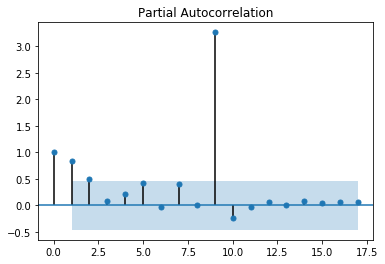

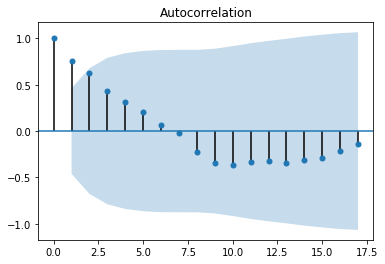

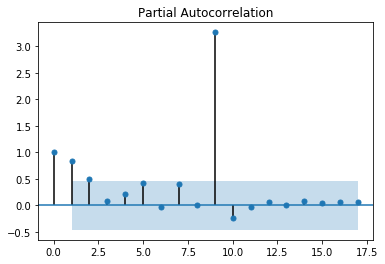

In [47]:
df = a_nuevo['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(7,1,1) - Año nuevo')

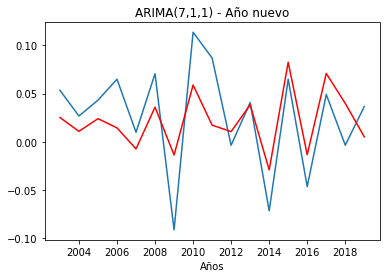

In [50]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log) 
model = ARIMA(df_log, order=(7,1,1))
results = model.fit(disp=-1)
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.xlabel('Años')
plt.title('ARIMA(7,1,1) - Año nuevo')

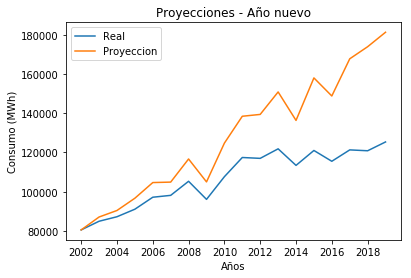

In [52]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)

plt.plot(df, label ='Real')
plt.plot(predictions_ARIMA, label='Proyeccion')
plt.xlabel('Años')
plt.ylabel('Consumo (MWh)')
plt.title('Proyecciones - Año nuevo')
plt.legend()
plt.show()

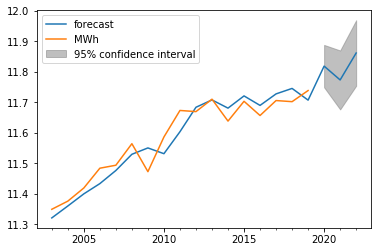

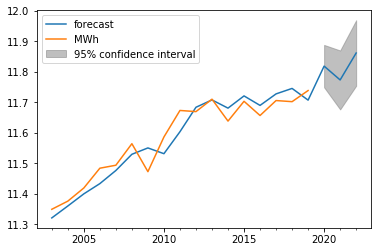

In [53]:
results.plot_predict(1,20)

In [54]:
pred['año nuevo']['ARIMA']=predictions_ARIMA['2017-01-01']

#### <p style="text-align: center">  <font color = 'red'> Aniversario de la Constitución de 1917

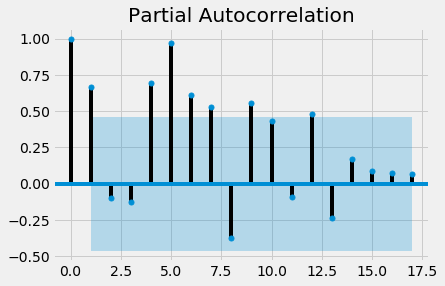

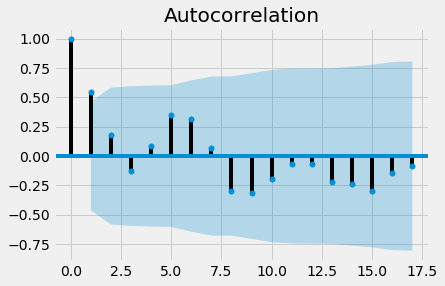

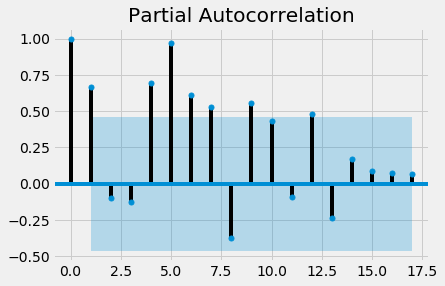

In [528]:
df = a_const['MWh'].astype(float)
plot_acf(df)
plot_pacf(df, method='ols')


Text(0.5,1,'ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

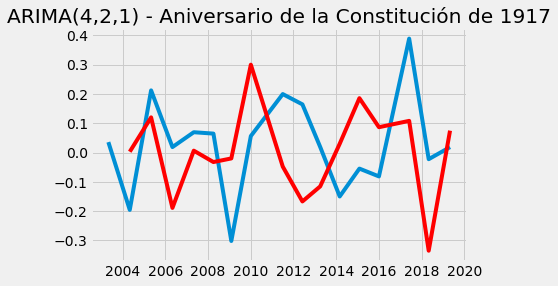

In [529]:
df_log = np.log(df)
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(0,2,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,1) - Aniversario de la Constitución de 1917')

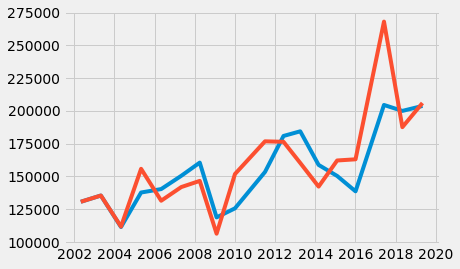

In [530]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

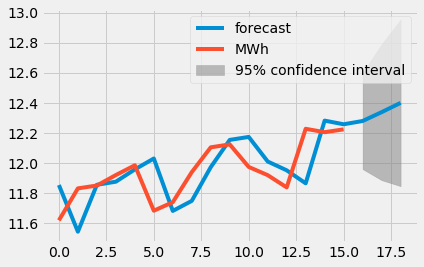

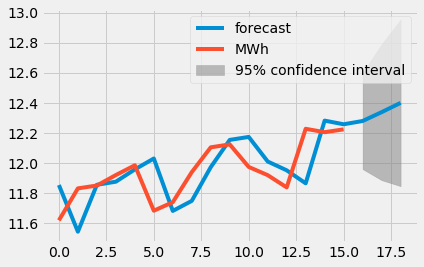

In [531]:
results.plot_predict(2,20)

In [532]:
pred['aniversario de la Constitución de 1917']['ARIMA']=predictions_ARIMA['2017-06-02 ']

#### <p style="text-align: center">  <font color = 'red'> Natalicio de Benito Juárez Garcia

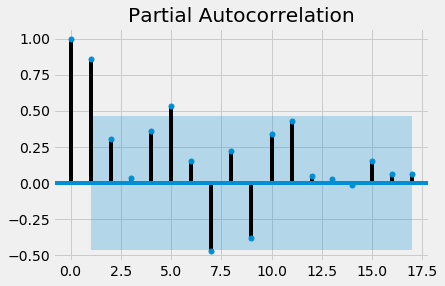

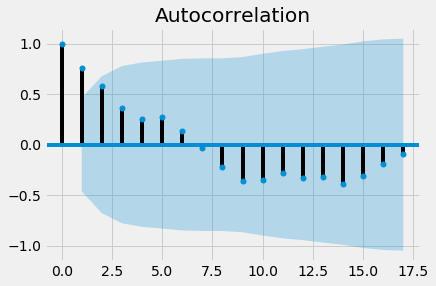

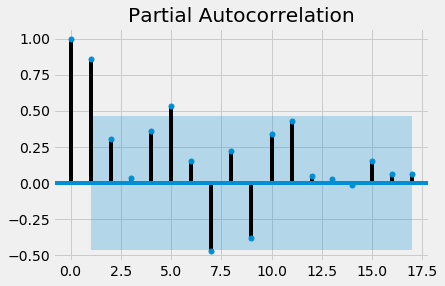

In [533]:
df = nat_bj['MWh'].astype(float)
df_log = np.log(df)
df_log = np.log(df)
plot_acf(df)
plot_pacf(df, method='ols')

Text(0.5,1,'ARIMA(4,2,0) - Natalicio de Benito Juarez')

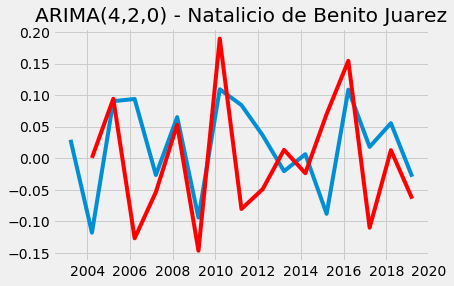

In [534]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(4,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(4,2,0) - Natalicio de Benito Juarez')

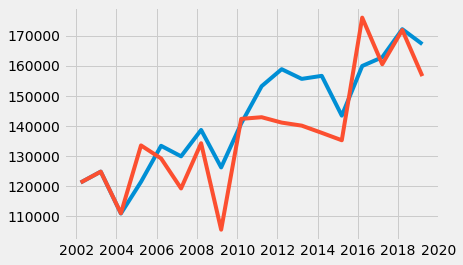

In [535]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

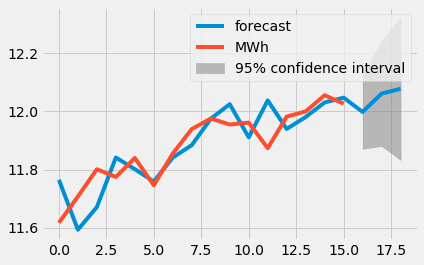

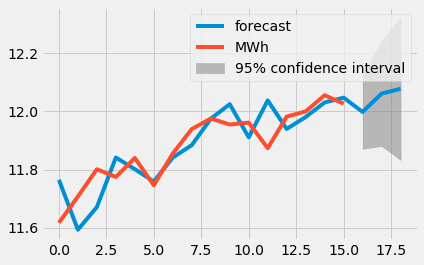

In [536]:
results.plot_predict(2,20)

In [537]:
pred['natalicio de Benito Juárez Garcia']['ARIMA']=predictions_ARIMA['2017-03-20 ']

#### <p style="text-align: center">  <font color = 'red'> Jueves Santo

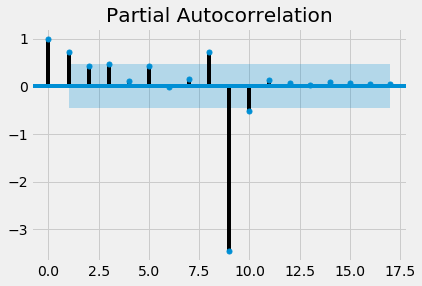

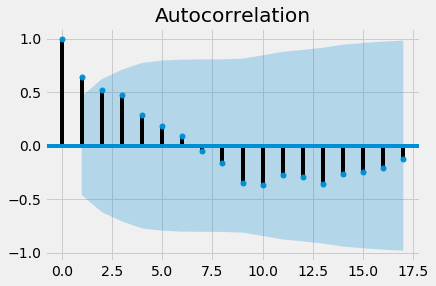

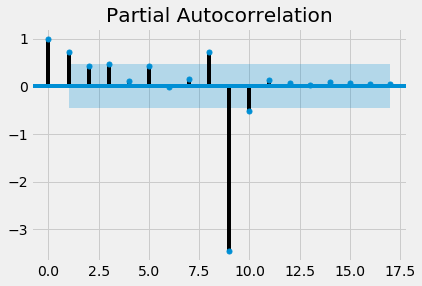

In [538]:
df = js['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(7,1,0) - Jueves Santo')

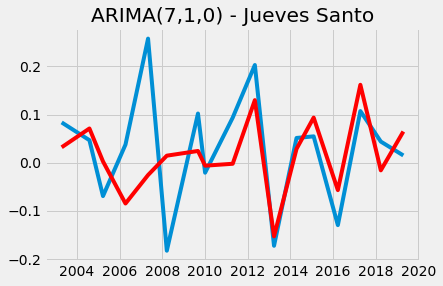

In [539]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq =1) 
model = ARIMA(df_log, order=(7,1,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(7,1,0) - Jueves Santo')

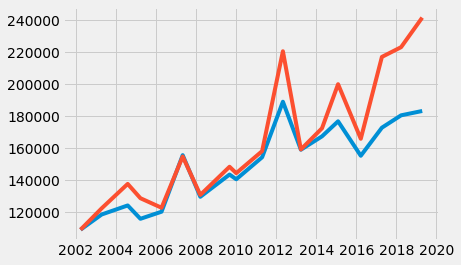

In [540]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

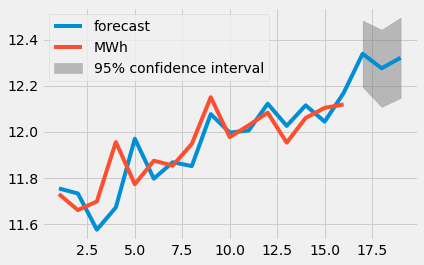

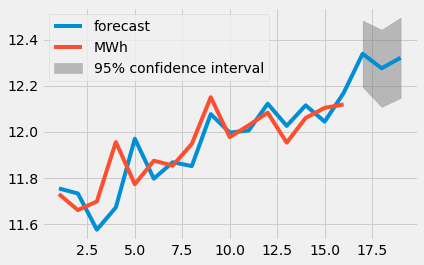

In [541]:
results.plot_predict(2,20)

In [542]:
pred['jueves santo']['ARIMA']=predictions_ARIMA['2017-04-13']

#### <p style="text-align: center">  <font color = 'red'> Viernes Santo

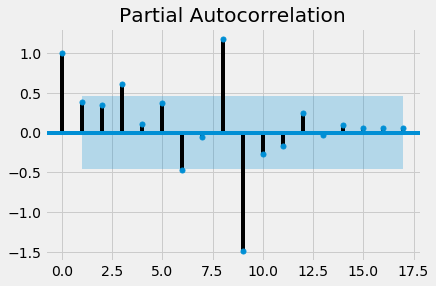

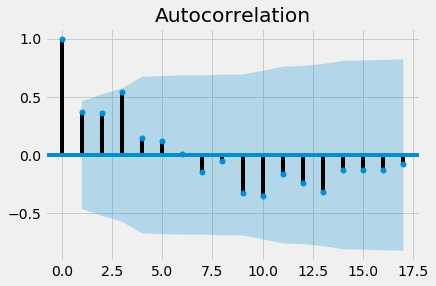

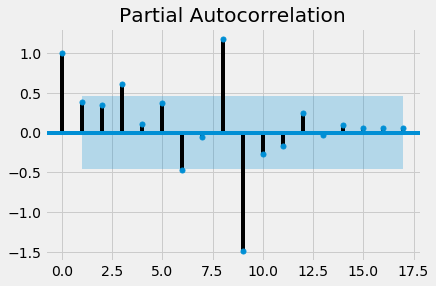

In [543]:
df = vs['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(0,2,1) - Viernes Santo')

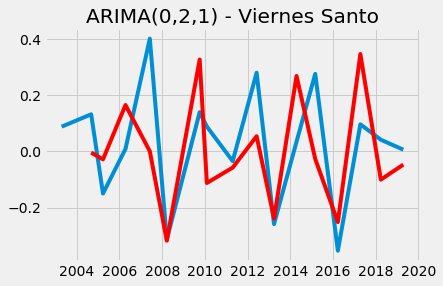

In [544]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(0,2,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(0,2,1) - Viernes Santo')

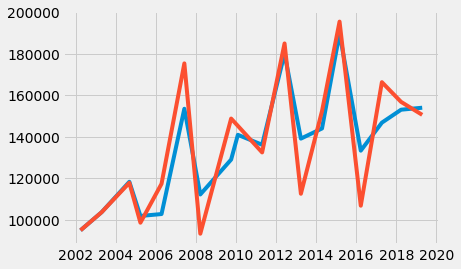

In [545]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

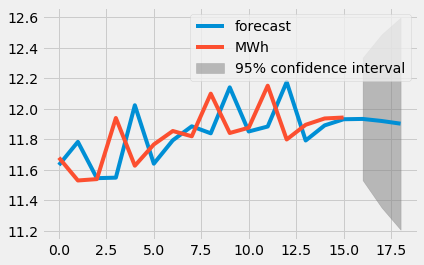

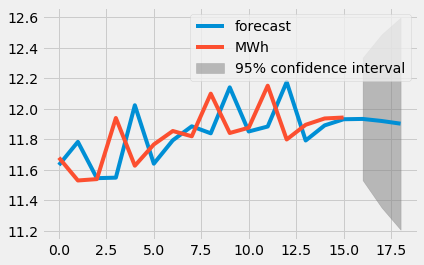

In [546]:
results.plot_predict(2,20)

In [549]:
pred['viernes santo']['ARIMA']=predictions_ARIMA['2017-04-14']

#### <p style="text-align: center">  <font color = 'red'> Dia del Trabajo

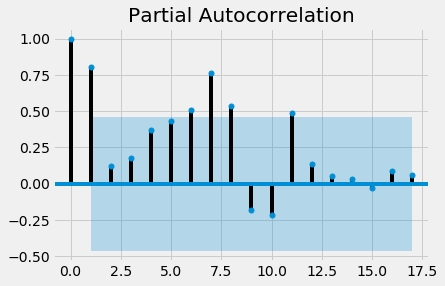

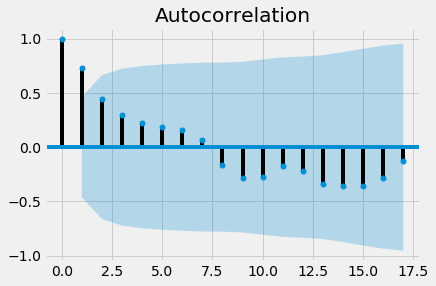

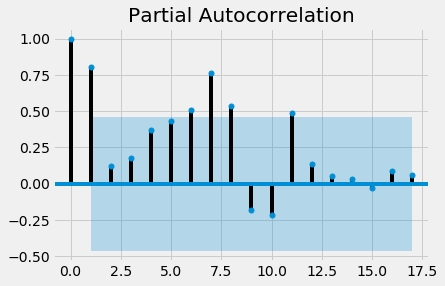

In [550]:
df = dt['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(5,1,0) - Día del Trabajo')

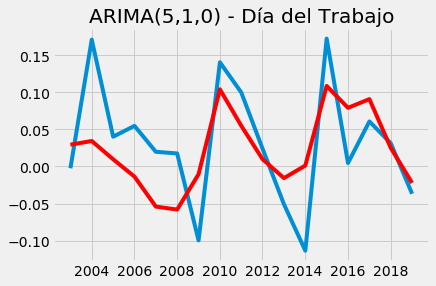

In [551]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq = 1) 
model = ARIMA(df_log, order=(5,1,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(5,1,0) - Día del Trabajo')

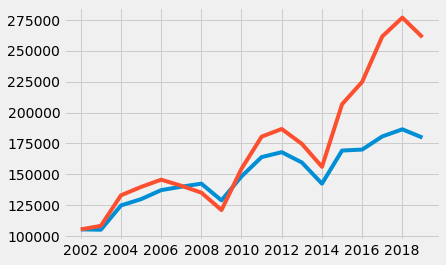

In [552]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

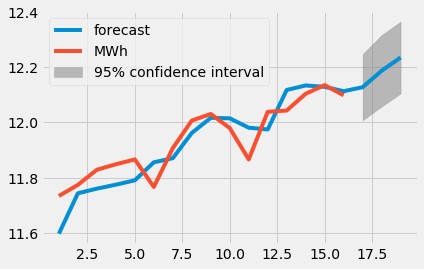

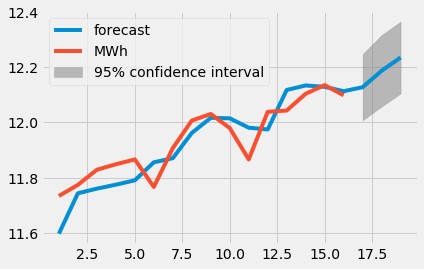

In [553]:
results.plot_predict(2,20)

In [554]:
pred['día del trabajo']['ARIMA']=predictions_ARIMA['2017-01-05']

#### <p style="text-align: center">  <font color = 'red'> Día de la madre

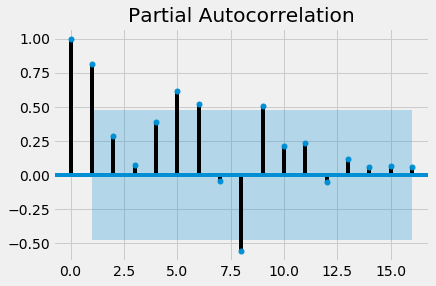

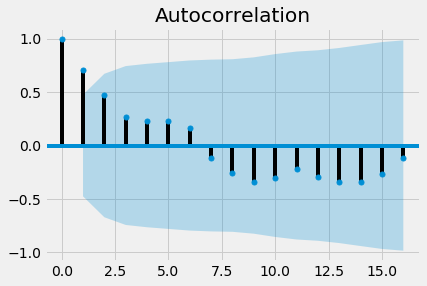

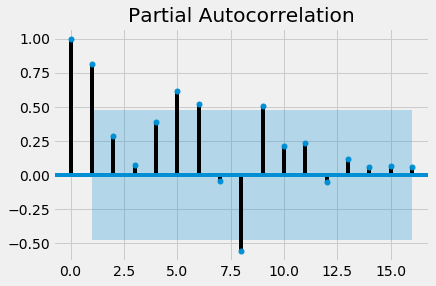

In [555]:
df = d_madre['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(5,1,1) - Día de la madre')

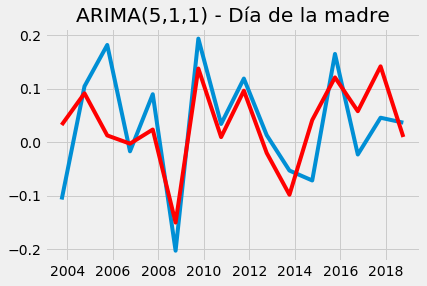

In [556]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(5,1,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.xlabel('Años')
plt.title('ARIMA(5,1,1) - Día de la madre')

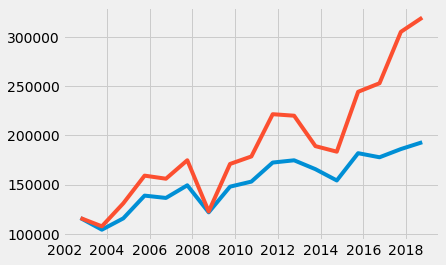

In [557]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

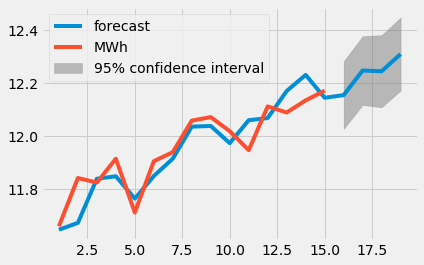

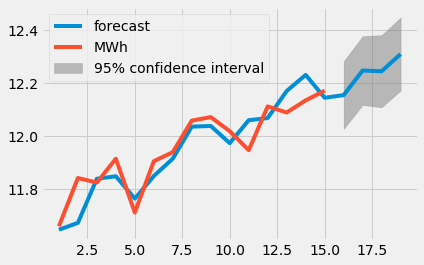

In [558]:
results.plot_predict(2,20)

In [559]:
pred['día de la madre']['ARIMA']=predictions_ARIMA['2017-10-05']

#### <p style="text-align: center">  <font color = 'red'> Día de la Independencia

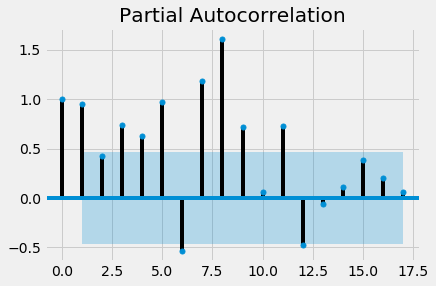

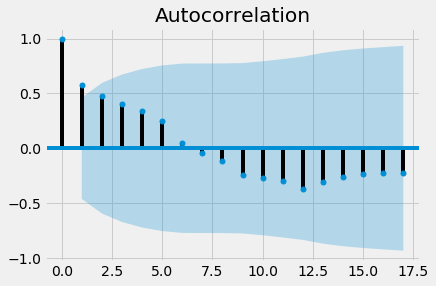

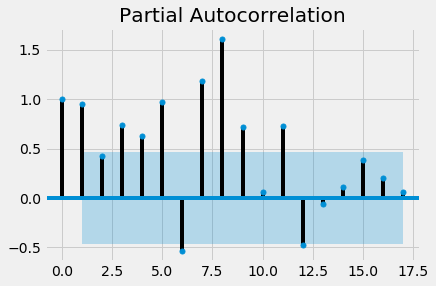

In [560]:
df = d_ind['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(3,2,1) - Día de la Independencia')

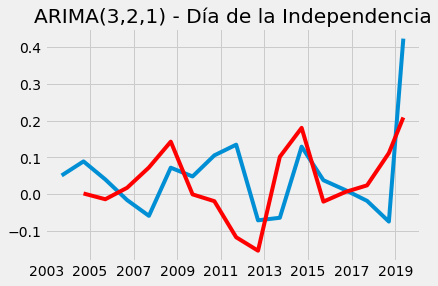

In [561]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(3,2,1))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(3,2,1) - Día de la Independencia')

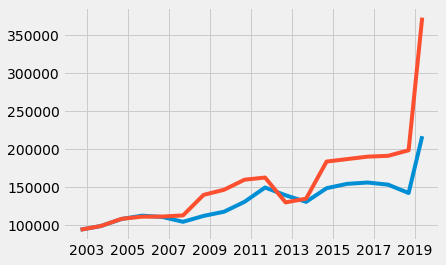

In [562]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

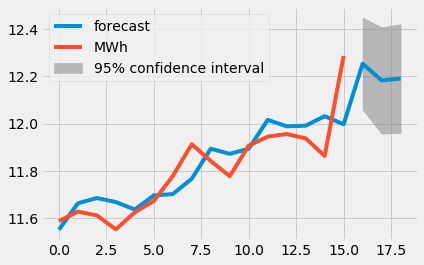

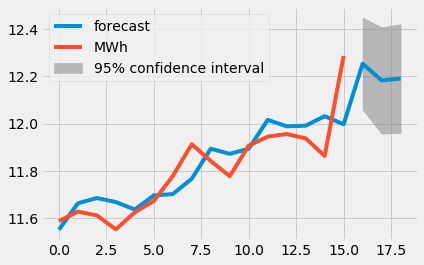

In [563]:
results.plot_predict(2,20)

In [564]:
pred['día de la Independencia']['ARIMA']=predictions_ARIMA['2017-09-16']

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Zapopan

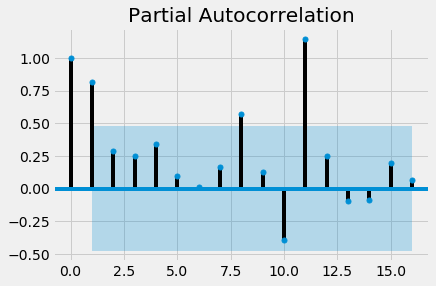

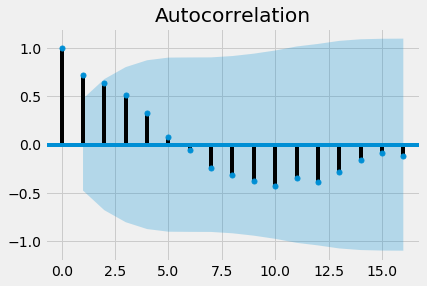

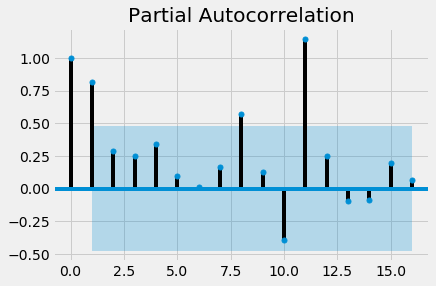

In [565]:
df = d_vz['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(5,2,0) - Día de la Virgen de Zapopan')

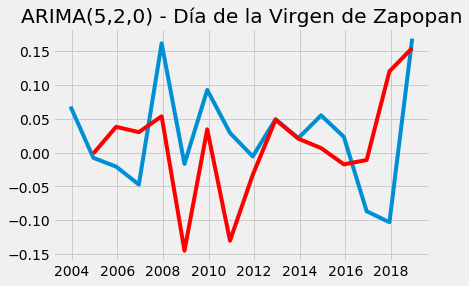

In [566]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(5,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(5,2,0) - Día de la Virgen de Zapopan')

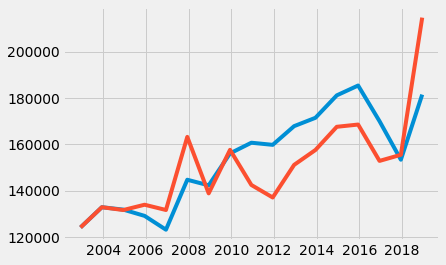

In [567]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

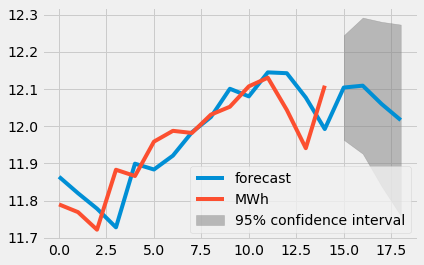

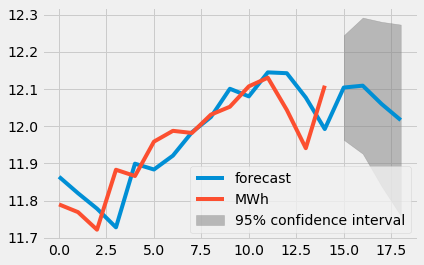

In [568]:
results.plot_predict(2,20)

In [569]:
pred['día de la Virgen de Zapopan']['ARIMA']=predictions_ARIMA['2017-12-10']

#### <p style="text-align: center">  <font color = 'red'> Día de los muertos

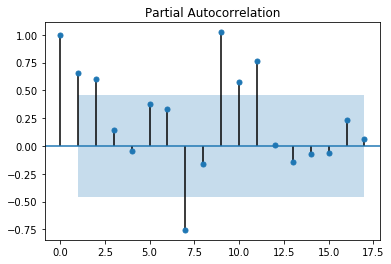

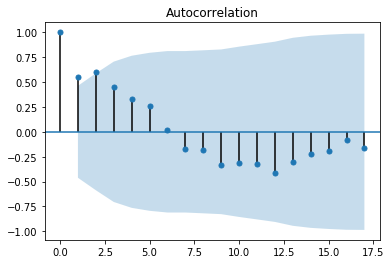

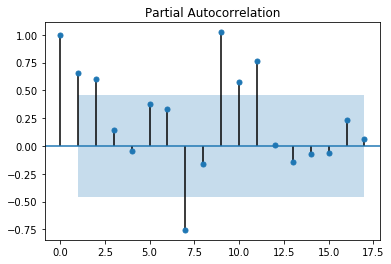

In [54]:
df = d_muer['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

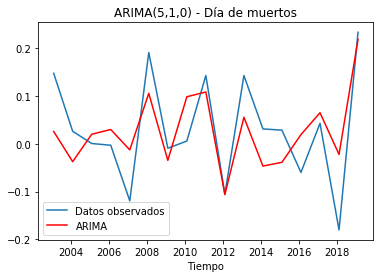

In [58]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(5,1,0))
results = model.fit()
plt.plot(df_log_shift, label = 'Datos observados')
plt.plot(results.fittedvalues, color='red', label = 'ARIMA')
plt.xlabel('Tiempo')
plt.title('ARIMA(5,1,0) - Día de muertos')
plt.legend()

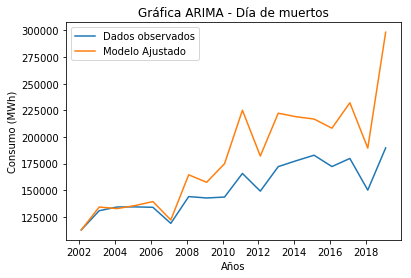

In [64]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df, label = 'Dados observados')
plt.plot(predictions_ARIMA, label = 'Modelo Ajustado')
plt.xlabel('Años')
plt.ylabel('Consumo (MWh)')
plt.title('Gráfica ARIMA - Día de muertos')
plt.legend()

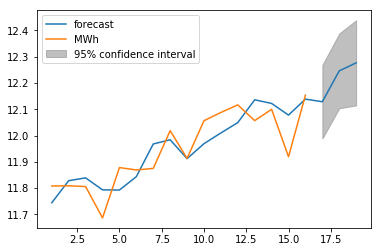

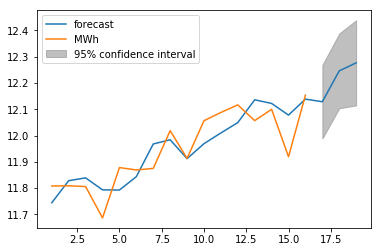

In [62]:
results.plot_predict(2,20)

In [63]:
pred['día de los muertos']['ARIMA']=predictions_ARIMA['2017-02-11']

#### <p style="text-align: center">  <font color = 'red'> Día de la Revolución

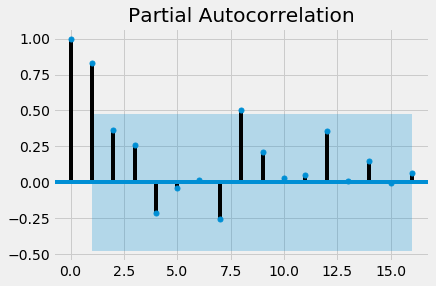

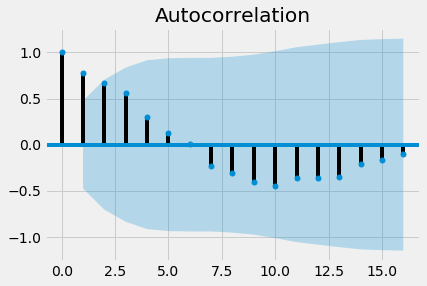

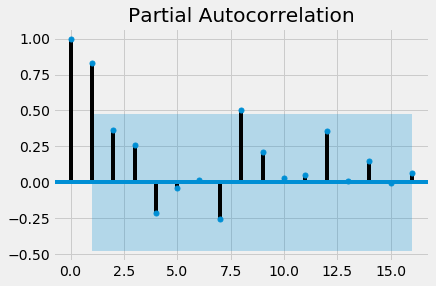

In [575]:
df = d_rev['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(6,2,0) - Día de los muertos')

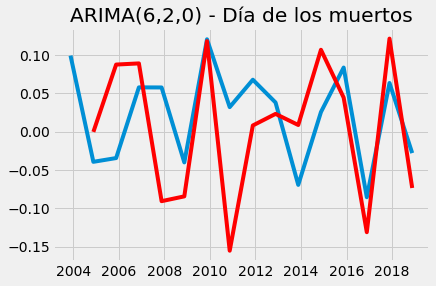

In [576]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(6,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(6,2,0) - Día de los muertos')

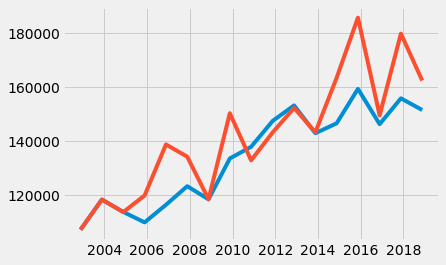

In [577]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

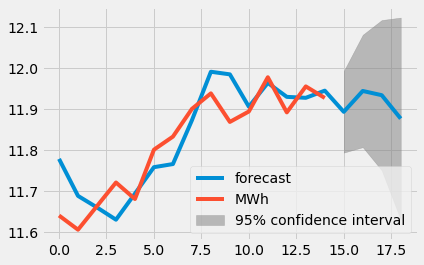

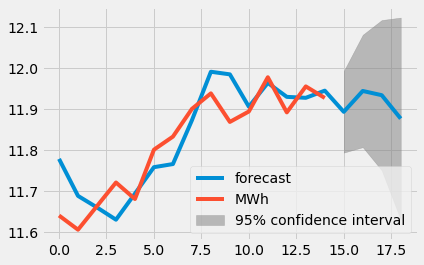

In [578]:
results.plot_predict(2,20)

In [579]:
pred['día de la Revolución']['ARIMA']=predictions_ARIMA['2017-11-20']

#### <p style="text-align: center">  <font color = 'red'> Día de la Virgen de Guadalupe

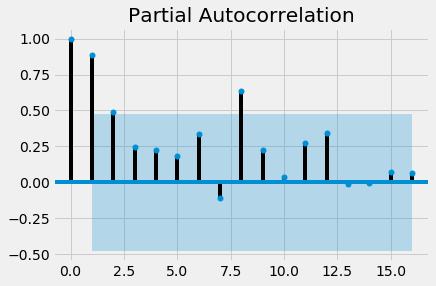

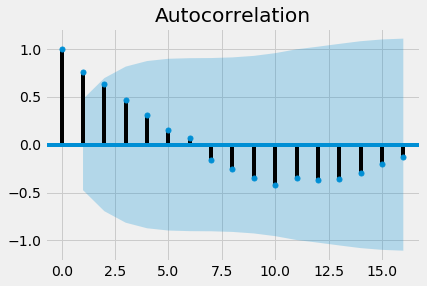

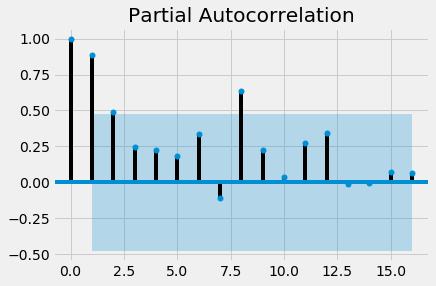

In [580]:
df = d_vg['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(7,1,0) - Día de la Virgen de Zapopan')

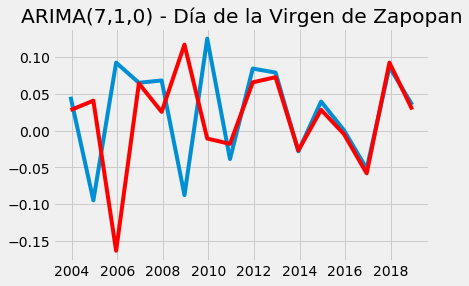

In [581]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(7,1,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(7,1,0) - Día de la Virgen de Zapopan')

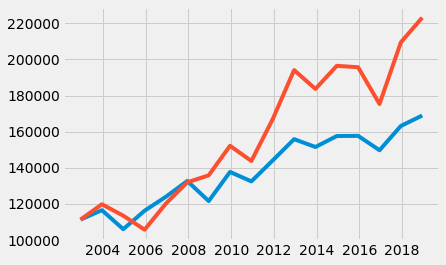

In [582]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

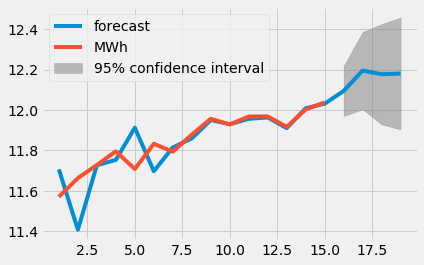

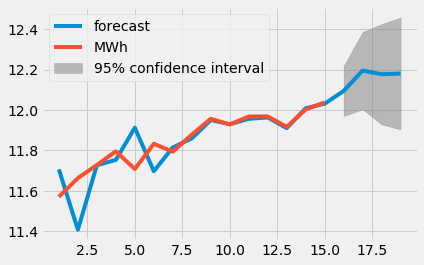

In [583]:
results.plot_predict(2,20)

In [584]:
pred['día de la Virgen de Guadalupe']['ARIMA']=predictions_ARIMA['2017-12-12']

#### <p style="text-align: center">  <font color = 'red'> Navidad

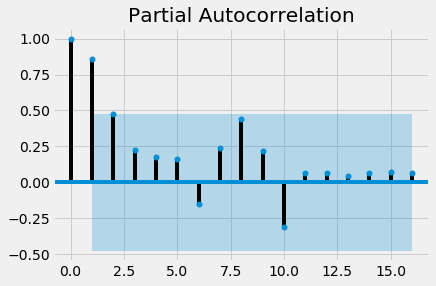

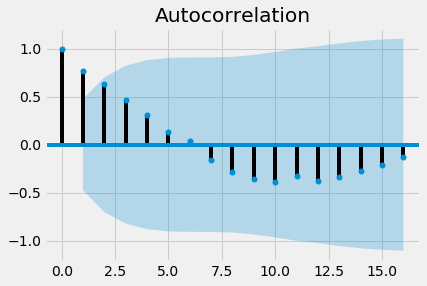

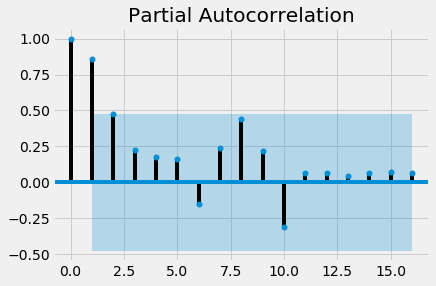

In [585]:
df = nav['MWh'].astype(float)
df_log = np.log(df)
plot_acf(df_log)
plot_pacf(df_log, method='ols')

Text(0.5,1,'ARIMA(1,2,0) - Navidad')

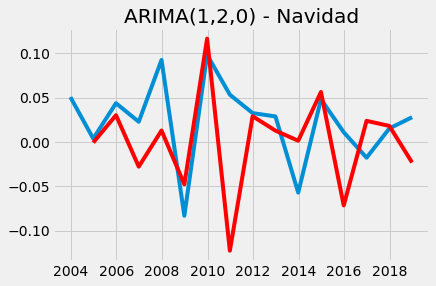

In [586]:
df_log_shift = df_log - df_log.shift()
decomposition = seasonal_decompose(df_log, freq=1) 
model = ARIMA(df_log, order=(1,2,0))
results = model.fit()
plt.plot(df_log_shift)
plt.plot(results.fittedvalues, color='red')
plt.title('ARIMA(1,2,0) - Navidad')

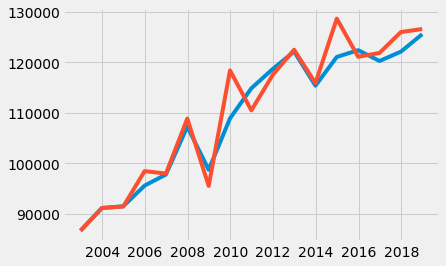

In [587]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log, index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

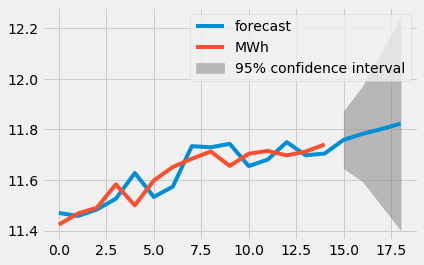

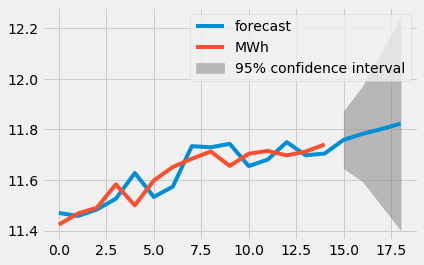

In [588]:
results.plot_predict(2,20)

In [589]:
pred['Navidad']['ARIMA']=predictions_ARIMA['2017-12-25']

# <p style="text-align: center">  <font color = 'darkblue'> Tercera Parte
### <p style="text-align: center">  <font color = 'black'> Errores

In [590]:
pred

,año nuevo,aniversario de la Constitución de 1917,natalicio de Benito Juárez Garcia,jueves santo,viernes santo,día del trabajo,día de la madre,día de la Independencia,día de la Virgen de Zapopan,día de los muertos,día de la Revolución,día de la Virgen de Guadalupe,Navidad
Regresión lineal 1 var,121629,148716,158033,164396,155818,163971,171532,123227,164571,150383,147081,151415,118724
Regresión lineal multivar,121468,141647,143338,159501,143283,147280,157692,154874,180752,179616,161165,158236,124284
ARIMA,167729,268072,160487,217028,166204,261633,305053,190962,155507,232089,179768,209463,125975


In [458]:
real

,año nuevo,aniversario de la Constitución de 1917,natalicio de Benito Juárez Garcia,jueves santo,viernes santo,día del trabajo,día de la madre,día de la Independencia,día de la Virgen de Zapopan,día de los muertos,día de la Revolución,día de la Virgen de Guadalupe,Navidad
Valor Real,121291.883,204478.861,162811.591,172791.208,146744.258,180629.581,186158.095,152975.3691,153389.46474,179852,155786.776,163133,122089.327155


In [617]:
error = pd.DataFrame(index = ['Regresión lineal 1 var','Regresión lineal multivar','ARIMA'],columns = names)

In [636]:
for j in range(3):
    for i in range(len(names)):
        error.iloc[j,i]= np.abs((real.iloc[0,i] - pred.iloc[j,i])/real.iloc[0,i])

In [637]:
error

,año nuevo,aniversario de la Constitución de 1917,natalicio de Benito Juárez Garcia,jueves santo,viernes santo,día del trabajo,día de la madre,día de la Independencia,día de la Virgen de Zapopan,día de los muertos,día de la Revolución,día de la Virgen de Guadalupe,Navidad
Regresión lineal 1 var,0.00278055,0.272707,0.0293529,0.0485851,0.0618317,0.0922254,0.0785684,0.194465,0.0728967,0.16385,0.0558809,0.0718314,0.0275641
Regresión lineal multivar,0.00145073,0.307279,0.11961,0.0769133,0.0235877,0.18463,0.152915,0.0124106,0.178386,0.00131115,0.0345255,0.0300165,0.0179789
ARIMA,0.382851,0.311002,0.0142758,0.256014,0.132611,0.448453,0.638677,0.248321,0.0138052,0.290444,0.153938,0.284,0.0318278


In [639]:
def highlight_min(data, color='yellow'):
    '''
    highlight the maximum in a Series or DataFrame
    '''
    attr = 'background-color: {}'.format(color)
    #remove % and cast to float
    data = data.replace('%','', regex=True).astype(float)
    if data.ndim == 1:  # Series from .apply(axis=0) or axis=1
        is_min = data == data.min()
        return [attr if v else '' for v in is_min]
    else:  # from .apply(axis=None)
        is_min = data == data.min().min()
        return pd.DataFrame(np.where(is_min, attr, ''),
                            index=data.index, columns=data.columns)

In [640]:
error.style.apply(highlight_min)

,año nuevo,aniversario de la Constitución de 1917,natalicio de Benito Juárez Garcia,jueves santo,viernes santo,día del trabajo,día de la madre,día de la Independencia,día de la Virgen de Zapopan,día de los muertos,día de la Revolución,día de la Virgen de Guadalupe,Navidad
Regresión lineal 1 var,0.00278055,0.272707,0.0293529,0.0485851,0.0618317,0.0922254,0.0785684,0.194465,0.0728967,0.16385,0.0558809,0.0718314,0.0275641
Regresión lineal multivar,0.00145073,0.307279,0.11961,0.0769133,0.0235877,0.18463,0.152915,0.0124106,0.178386,0.00131115,0.0345255,0.0300165,0.0179789
ARIMA,0.382851,0.311002,0.0142758,0.256014,0.132611,0.448453,0.638677,0.248321,0.0138052,0.290444,0.153938,0.284,0.0318278
